# LAB 2 CapyMOA
## Authors: AHMED Ayan, AHMED Rayyan

# Task Selection
We will be working on the Covtype dataset so it is essentially a classification task. For more details on the dataset, refer to the report.

In [1]:
pip install capymoa==0.7.0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 25.3 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=42209477c8458163e7ca35a3f5a5b76914f3797f82f3366e9e668bddf35de45d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
# Import necessary libraries
import capymoa
from capymoa.datasets import Covtype
from capymoa.stream.generator import SEA
from capymoa.datasets import Covtype
from capymoa.evaluation import prequential_evaluation
from capymoa.classifier import (
    HoeffdingTree,
    NoChange,
    MajorityClass,
    OnlineBagging,
    LeveragingBagging,
    AdaptiveRandomForestClassifier,
    StreamingRandomPatches,
    OnlineSmoothBoost,
    OzaBoost,
    StreamingGradientBoostedTrees
)
from moa.streams import ConceptDriftStream
from capymoa.stream.drift import DriftStream, Drift, AbruptDrift, GradualDrift

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Exploration

## Load Dataset

In [3]:
stream = Covtype()
schema = stream.get_schema()

## Statistics on Data Stream
The size of the snapshot that we would be using is 51000 and it is stored in the variable total_samples (max_instances).

In [4]:
total_samples = 51000
print("Label Values")
print(schema._label_values)
num_classes=schema.get_num_classes()
num_features=schema.get_num_attributes()
print(f"Number of classes: {num_classes}")
print(f"Number of features: {num_features}")
print(f"Number of samples or size of the snapshot used: {total_samples}")

Label Values
['1', '2', '3', '4', '5', '6', '7']
Number of classes: 7
Number of features: 54
Number of samples or size of the snapshot used: 51000


## Data Type Description
The dataset seems mixed with both numerical and categorical features where the catagorical features are binary in nature.

In [5]:
header = schema.get_moa_header()
header_str=str(header)
numeric_features = sum(1 for line in header_str.splitlines() if 'numeric' in line)
categorical_features = num_features - numeric_features
print(f"Numeric attributes: {numeric_features}")
print(f"Categorical attributes: {categorical_features}")

Numeric attributes: 10
Categorical attributes: 44



## Class Distribution & Time-based Trends

Overall class distribution:
Class 5: 4.74%
Class 2: 57.99%
Class 1: 20.33%
Class 7: 4.24%
Class 3: 4.24%
Class 6: 4.24%
Class 4: 4.24%


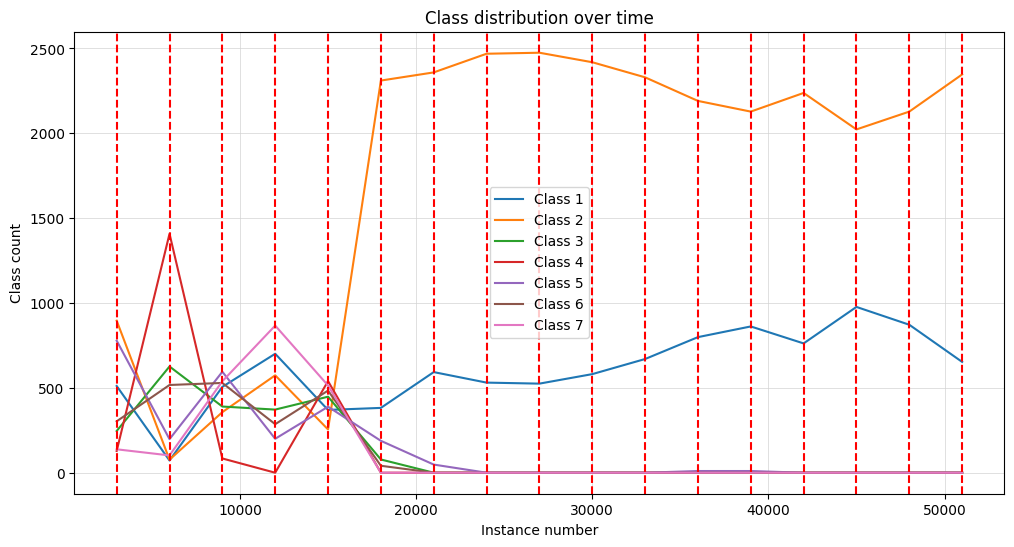

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Parameters
window_size = 3000
total_samples = 51000  # Total samples to analyze
class_counts_over_time = []
instance_numbers = np.arange(window_size, total_samples + 1, window_size)

# Windowed sampling
for i in range(0, total_samples, window_size):
    window_classes = []
    for _ in range(window_size):
        instance = stream.next_instance()
        window_classes.append(instance.y_label)
    window_class_count = Counter(window_classes)
    class_counts_over_time.append(window_class_count)

# Aggregate class distribution
total_class_counts = sum((Counter(dict(count)) for count in class_counts_over_time), Counter())
print("Overall class distribution:")
for class_label, count in total_class_counts.items():
    print(f"Class {class_label}: {count/total_samples*100:.2f}%")

# Prepare DataFrame for plotting
class_labels = schema.get_label_values()
df_class_counts = pd.DataFrame(class_counts_over_time, index=instance_numbers).fillna(0)

# Plotting class distribution changes over time
plt.figure(figsize=(12, 6))
for class_label in class_labels:
    plt.plot(df_class_counts.index, df_class_counts[class_label], label=f"Class {class_label}")

# Add vertical dashed lines for window boundaries
for x in instance_numbers:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=1.5)

# Add labels, title, legend, and grid
plt.xlabel("Instance number")
plt.ylabel("Class count")
plt.title("Class distribution over time")
plt.legend()
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
plt.show()


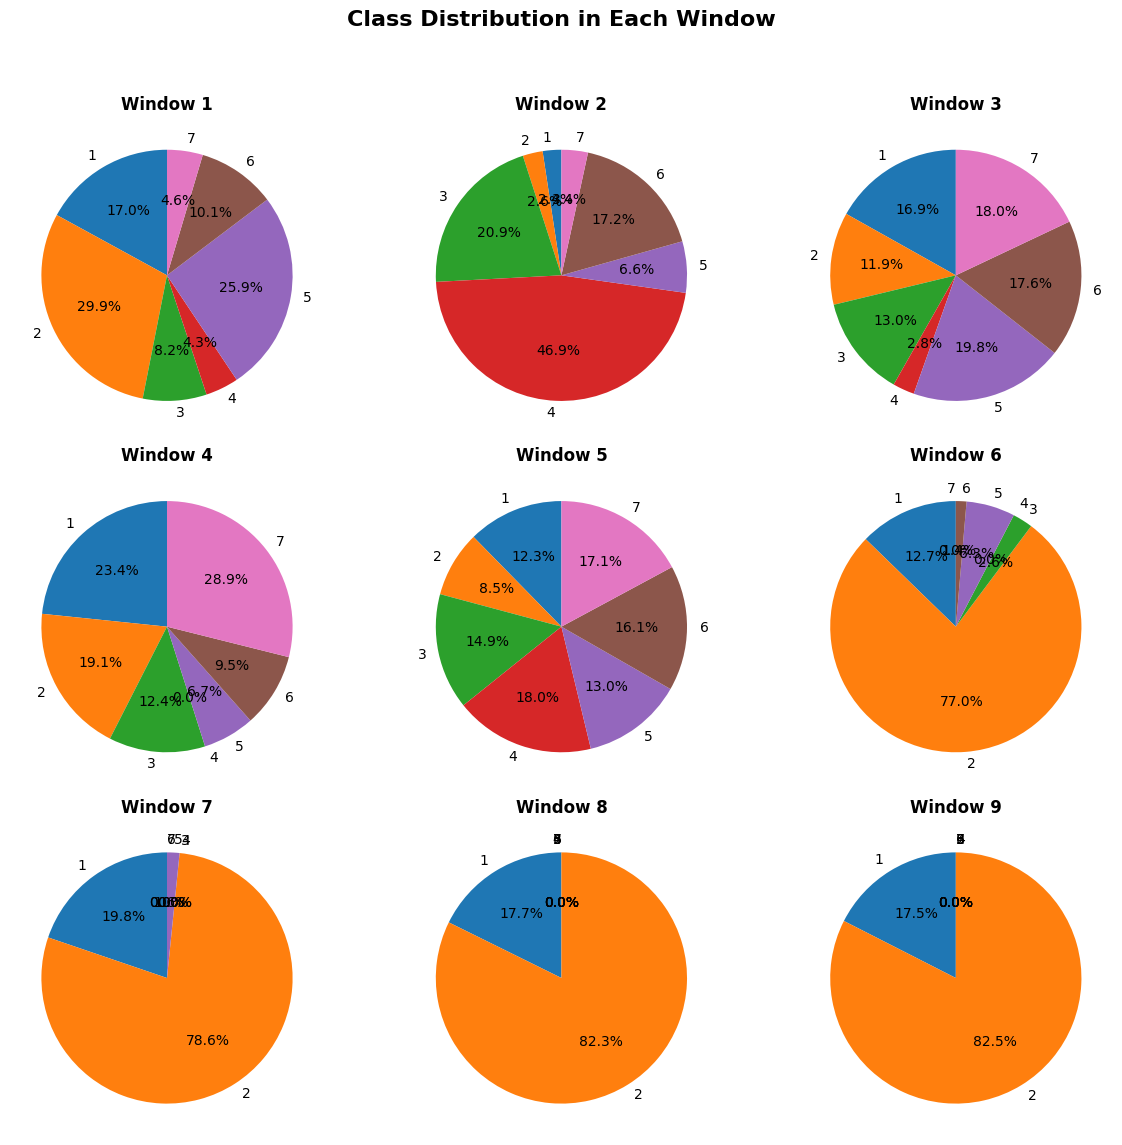

In [7]:
stream = Covtype()
schema = stream.get_schema()
# Setting up the figure for a 3x3 grid of pie charts
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("Class Distribution in Each Window", fontsize=16, weight='bold')

# Plot each window's distribution as a pie chart in the 3x3 grid
for idx, ax in enumerate(axes.flat):
    if idx < len(class_counts_over_time):  # Ensure we have data for this window
        window_class_counts = class_counts_over_time[idx]
        # Extract data for the pie chart
        counts = [window_class_counts.get(label, 0) for label in class_labels]
        ax.pie(counts, labels=class_labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
        ax.set_title(f"Window {idx + 1}", fontsize=12, weight='bold')
    else:
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


We observe that there is huge class imbalance especially after around 16000 instances with the majority classes being 1 and 2.

In [8]:
stream = Covtype()
schema = stream.get_schema()
from scipy.stats import gaussian_kde
continuous_features = list(range(10))
categorical_features = list(range(10, 54))
num_windows=total_samples//window_size
window_indices = list(range(total_samples//window_size))
print(window_indices)
i=0
feature_counts=[]
label_counts=[]

while stream.has_more_instances() and i < total_samples:
    inst = stream.next_instance()
    features = inst.x
    label = inst.y_label

    feature_counts.append(features)
    label_counts.append(label)
    i+=1

features_df = pd.DataFrame(feature_counts)
display(features_df)
label_df = pd.DataFrame(label_counts)
display(label_df)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50995,2959.0,130.0,12.0,272.0,33.0,4970.0,240.0,233.0,121.0,6454.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50996,2955.0,137.0,8.0,242.0,29.0,4948.0,233.0,237.0,136.0,6426.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50997,2952.0,125.0,9.0,212.0,26.0,4926.0,236.0,234.0,128.0,6398.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50998,2949.0,113.0,9.0,182.0,23.0,4904.0,236.0,231.0,126.0,6369.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0
0,5
1,5
2,2
3,2
4,5
...,...
50995,2
50996,2
50997,2
50998,2


## Plotting the Distribution of Some Numerical features Over Time
### Elevation

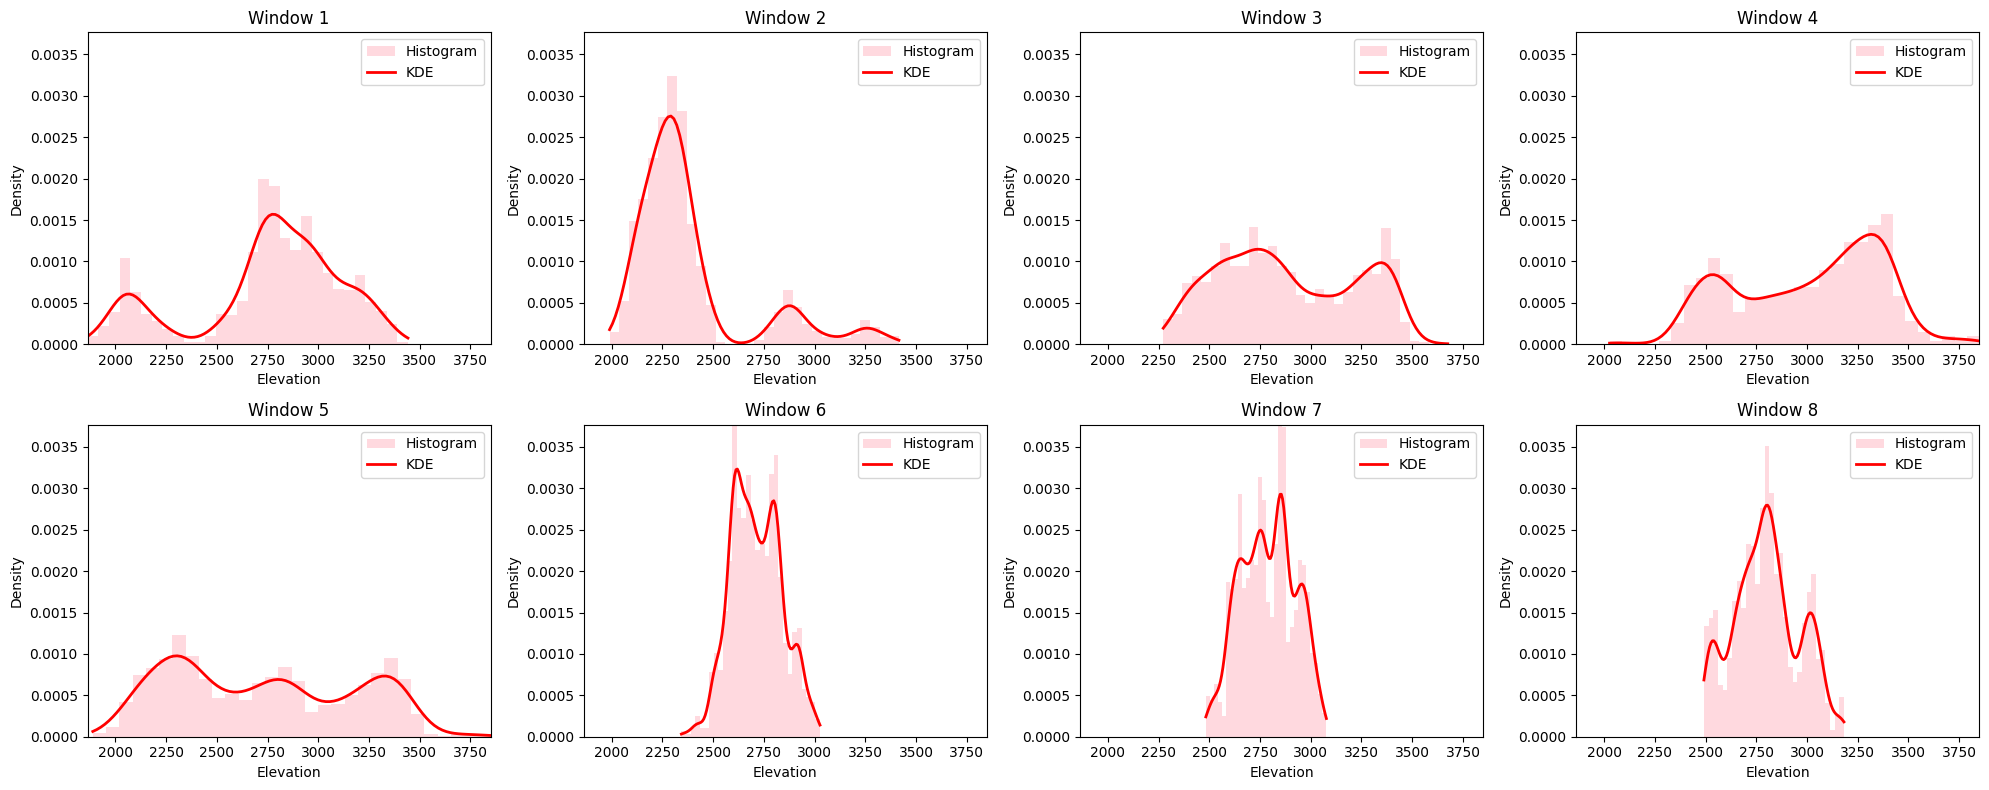

In [9]:
# Define the feature to analyze
feature_idx = 0  # Index of "Elevation" in the features list
feature_name = "Elevation"

# Number of bins for the histogram
num_bins = 30

# Compute the x-axis limits based on the entire dataset for this feature
x_min = features_df.iloc[:, feature_idx].min()
x_max = features_df.iloc[:, feature_idx].max()

# Determine y-axis limits based on maximum KDE density across all windows
y_max = 0
for i in range(num_windows):
    window_data = features_df.iloc[i * window_size: (i + 1) * window_size, feature_idx]
    kde = gaussian_kde(window_data)
    y_vals = kde(np.linspace(x_min, x_max, 100))
    y_max = max(y_max, y_vals.max())  # Update y_max with the highest density value found

# Plot histograms with KDE lines for each window
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    # Extract feature values for the current window
    window_data = features_df.iloc[i * window_size: (i + 1) * window_size, feature_idx]

    # Plot histogram
    ax.hist(window_data, bins=num_bins, density=True, alpha=0.6, color='pink', label='Histogram')

    # Calculate KDE
    kde = gaussian_kde(window_data)
    x_vals = np.linspace(window_data.min(), window_data.max(), 100)
    y_vals = kde(x_vals)

    # Plot the KDE line
    ax.plot(x_vals, y_vals, color='red', linewidth=2, label='KDE')

    # Set the same x and y limits for all plots
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)

    # Set titles and labels
    ax.set_title(f"Window {i + 1}")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

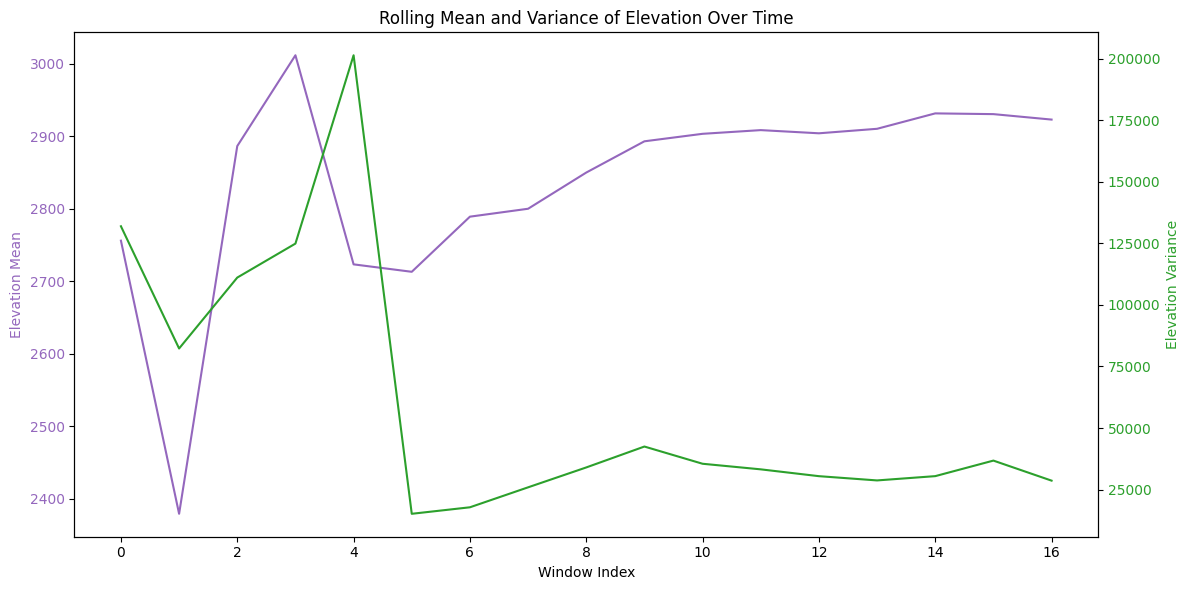

In [10]:
feature_idx = 0  # For "Elevation"
feature_name = "Elevation"

# Calculate rolling mean and variance for the selected feature
rolling_means = []
rolling_variances = []

for i in range(num_windows):
    # Extract the data for the current window
    window_data = features_df.iloc[i*window_size:(i+1)*window_size, feature_idx]
    rolling_means.append(window_data.mean())
    rolling_variances.append(window_data.var())

# Plot the rolling mean and variance over time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Rolling Mean
ax1.set_xlabel("Window Index")
ax1.set_ylabel(f"{feature_name} Mean", color="tab:purple")
ax1.plot(window_indices, rolling_means, label=f"{feature_name} Mean", color="tab:purple")
ax1.tick_params(axis="y", labelcolor="tab:purple")

# Rolling Variance (second y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel(f"{feature_name} Variance", color="tab:green")
ax2.plot(window_indices, rolling_variances, label=f"{feature_name} Variance", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

plt.title(f"Rolling Mean and Variance of {feature_name} Over Time")
fig.tight_layout()
plt.show()

### Aspect

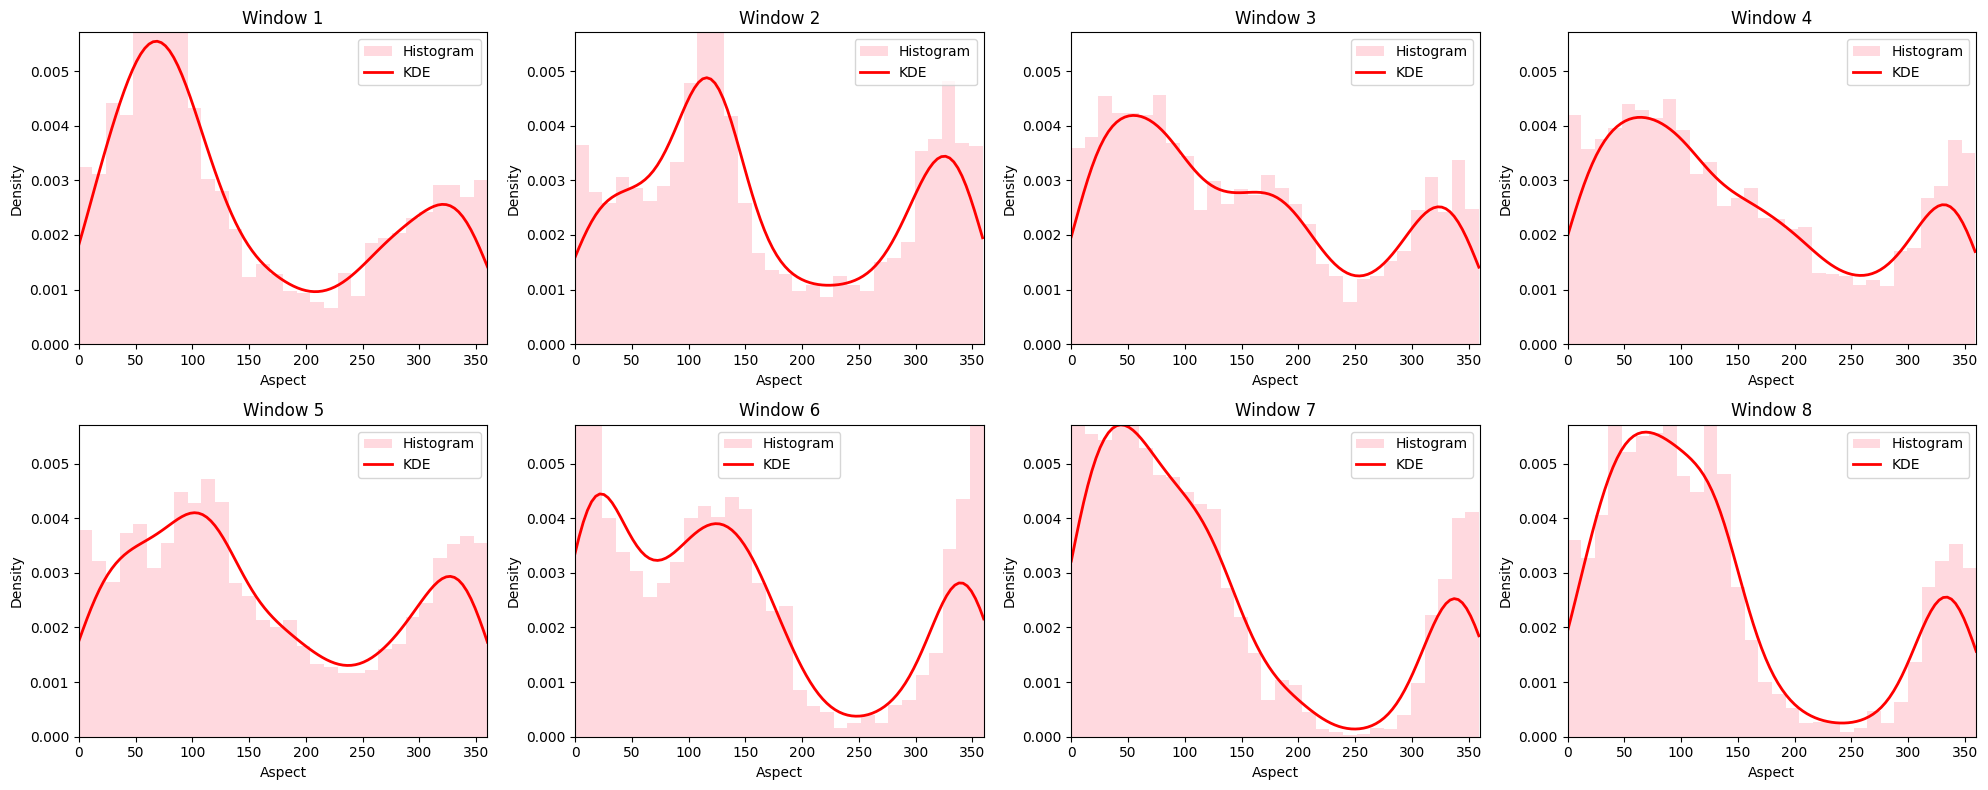

In [12]:
# Define the feature to analyze
feature_idx = 1  # Index of "Aspect" in the features list
feature_name = "Aspect"

# Number of bins for the histogram
num_bins = 30

# Compute the x-axis limits based on the entire dataset for this feature
x_min = features_df.iloc[:, feature_idx].min()
x_max = features_df.iloc[:, feature_idx].max()

# Determine y-axis limits based on maximum KDE density across all windows
y_max = 0
for i in range(num_windows):
    window_data = features_df.iloc[i * window_size: (i + 1) * window_size, feature_idx]
    kde = gaussian_kde(window_data)
    y_vals = kde(np.linspace(x_min, x_max, 100))
    y_max = max(y_max, y_vals.max())  # Update y_max with the highest density value found

# Plot histograms with KDE lines for each window
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    # Extract feature values for the current window
    window_data = features_df.iloc[i * window_size: (i + 1) * window_size, feature_idx]

    # Plot histogram
    ax.hist(window_data, bins=num_bins, density=True, alpha=0.6, color='pink', label='Histogram')

    # Calculate KDE
    kde = gaussian_kde(window_data)
    x_vals = np.linspace(window_data.min(), window_data.max(), 100)
    y_vals = kde(x_vals)

    # Plot the KDE line
    ax.plot(x_vals, y_vals, color='red', linewidth=2, label='KDE')

    # Set the same x and y limits for all plots
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)

    # Set titles and labels
    ax.set_title(f"Window {i + 1}")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

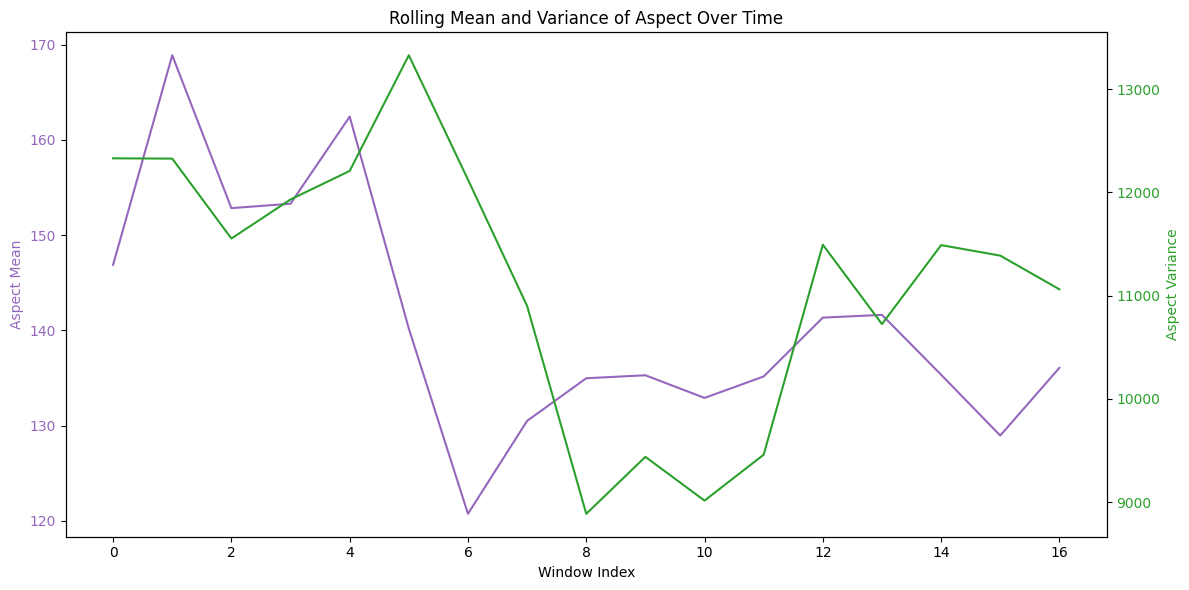

In [13]:
feature_idx = 1  # For "Aspect"
feature_name = "Aspect"

# Calculate rolling mean and variance for the selected feature
rolling_means = []
rolling_variances = []

for i in range(num_windows):
    # Extract the data for the current window
    window_data = features_df.iloc[i*window_size:(i+1)*window_size, feature_idx]
    rolling_means.append(window_data.mean())
    rolling_variances.append(window_data.var())

# Plot the rolling mean and variance over time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Rolling Mean
ax1.set_xlabel("Window Index")
ax1.set_ylabel(f"{feature_name} Mean", color="tab:purple")
ax1.plot(window_indices, rolling_means, label=f"{feature_name} Mean", color="tab:purple")
ax1.tick_params(axis="y", labelcolor="tab:purple")

# Rolling Variance (second y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel(f"{feature_name} Variance", color="tab:green")
ax2.plot(window_indices, rolling_variances, label=f"{feature_name} Variance", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

plt.title(f"Rolling Mean and Variance of {feature_name} Over Time")
fig.tight_layout()
plt.show()

### Slope

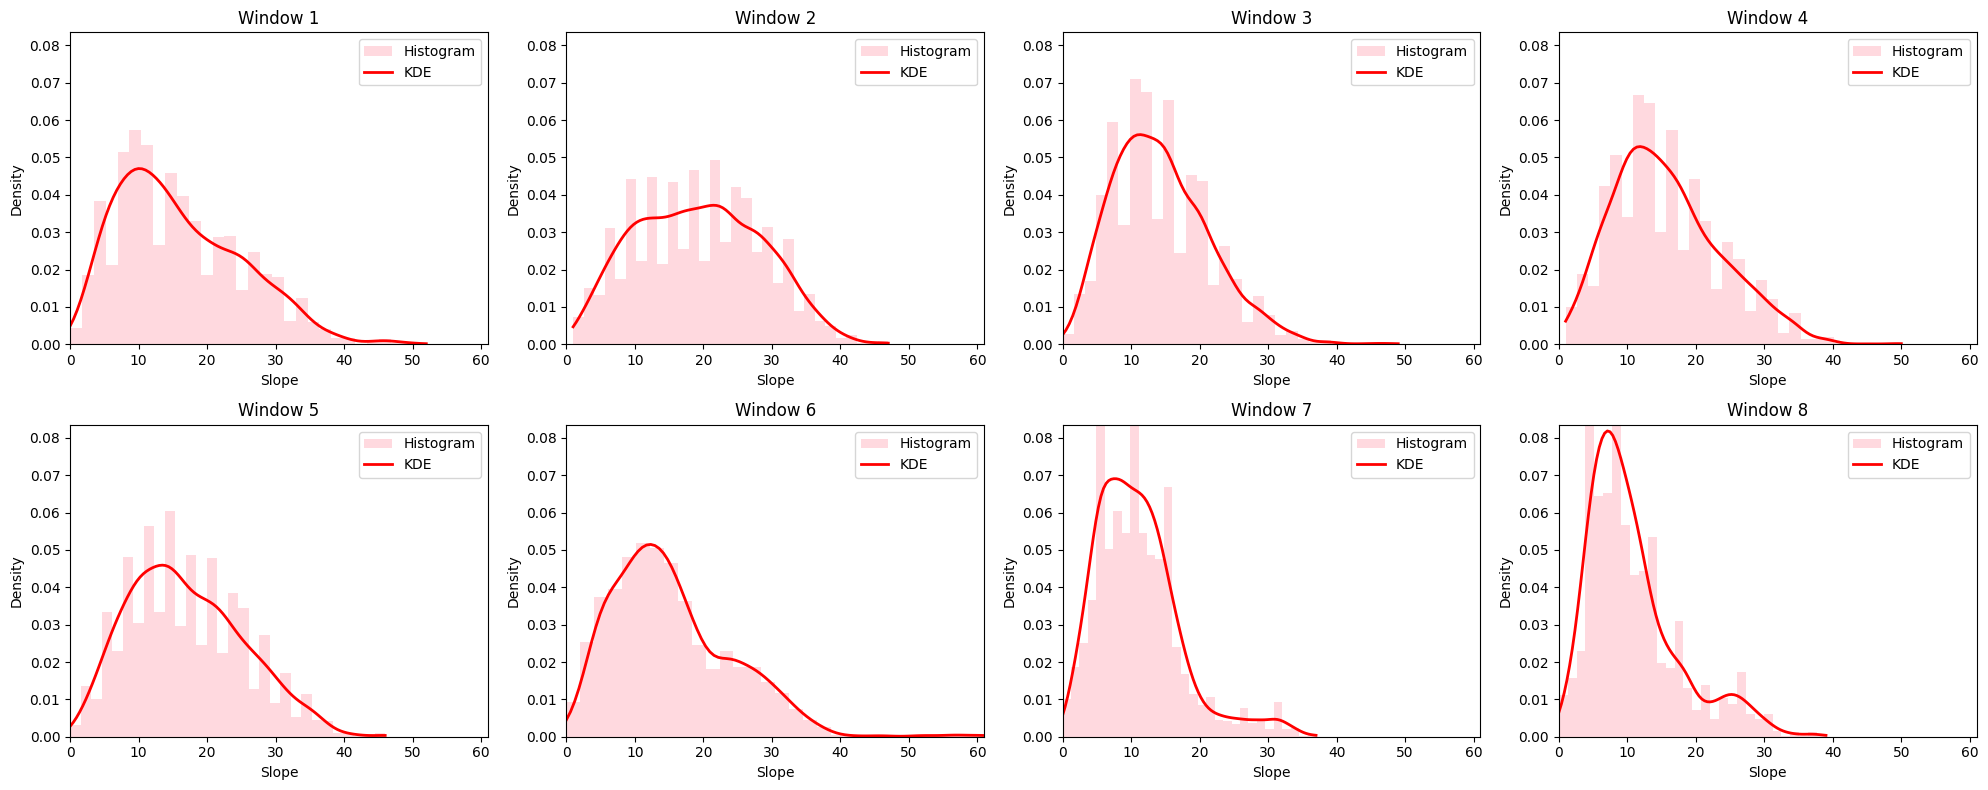

In [14]:
# Define the feature to analyze
feature_idx =2   # Index of "Slope" in the features list
feature_name = "Slope"

# Number of bins for the histogram
num_bins = 30

# Compute the x-axis limits based on the entire dataset for this feature
x_min = features_df.iloc[:, feature_idx].min()
x_max = features_df.iloc[:, feature_idx].max()

# Determine y-axis limits based on maximum KDE density across all windows
y_max = 0
for i in range(num_windows):
    window_data = features_df.iloc[i * window_size: (i + 1) * window_size, feature_idx]
    kde = gaussian_kde(window_data)
    y_vals = kde(np.linspace(x_min, x_max, 100))
    y_max = max(y_max, y_vals.max())  # Update y_max with the highest density value found

# Plot histograms with KDE lines for each window
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    # Extract feature values for the current window
    window_data = features_df.iloc[i * window_size: (i + 1) * window_size, feature_idx]

    # Plot histogram
    ax.hist(window_data, bins=num_bins, density=True, alpha=0.6, color='pink', label='Histogram')

    # Calculate KDE
    kde = gaussian_kde(window_data)
    x_vals = np.linspace(window_data.min(), window_data.max(), 100)
    y_vals = kde(x_vals)

    # Plot the KDE line
    ax.plot(x_vals, y_vals, color='red', linewidth=2, label='KDE')

    # Set the same x and y limits for all plots
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)

    # Set titles and labels
    ax.set_title(f"Window {i + 1}")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

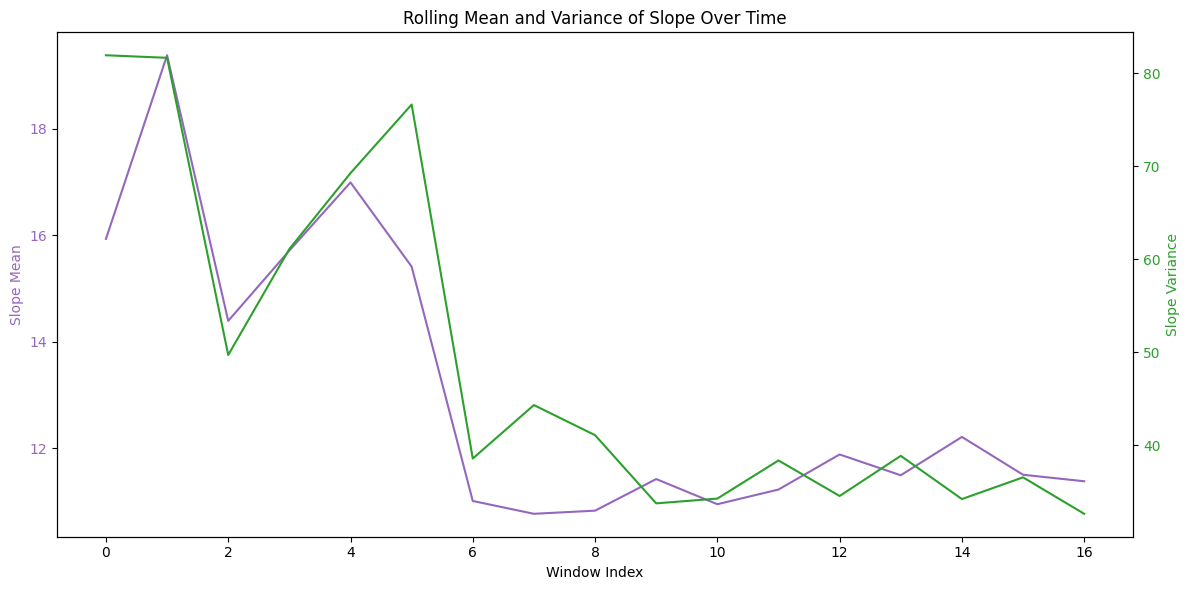

In [15]:
# Define the feature to analyze
feature_idx =2   # Index of "Slope" in the features list
feature_name = "Slope"

# Calculate rolling mean and variance for the selected feature
rolling_means = []
rolling_variances = []

for i in range(num_windows):
    # Extract the data for the current window
    window_data = features_df.iloc[i*window_size:(i+1)*window_size, feature_idx]
    rolling_means.append(window_data.mean())
    rolling_variances.append(window_data.var())

# Plot the rolling mean and variance over time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Rolling Mean
ax1.set_xlabel("Window Index")
ax1.set_ylabel(f"{feature_name} Mean", color="tab:purple")
ax1.plot(window_indices, rolling_means, label=f"{feature_name} Mean", color="tab:purple")
ax1.tick_params(axis="y", labelcolor="tab:purple")

# Rolling Variance (second y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel(f"{feature_name} Variance", color="tab:green")
ax2.plot(window_indices, rolling_variances, label=f"{feature_name} Variance", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

plt.title(f"Rolling Mean and Variance of {feature_name} Over Time")
fig.tight_layout()
plt.show()

### Horizontal Distance to Hydrology

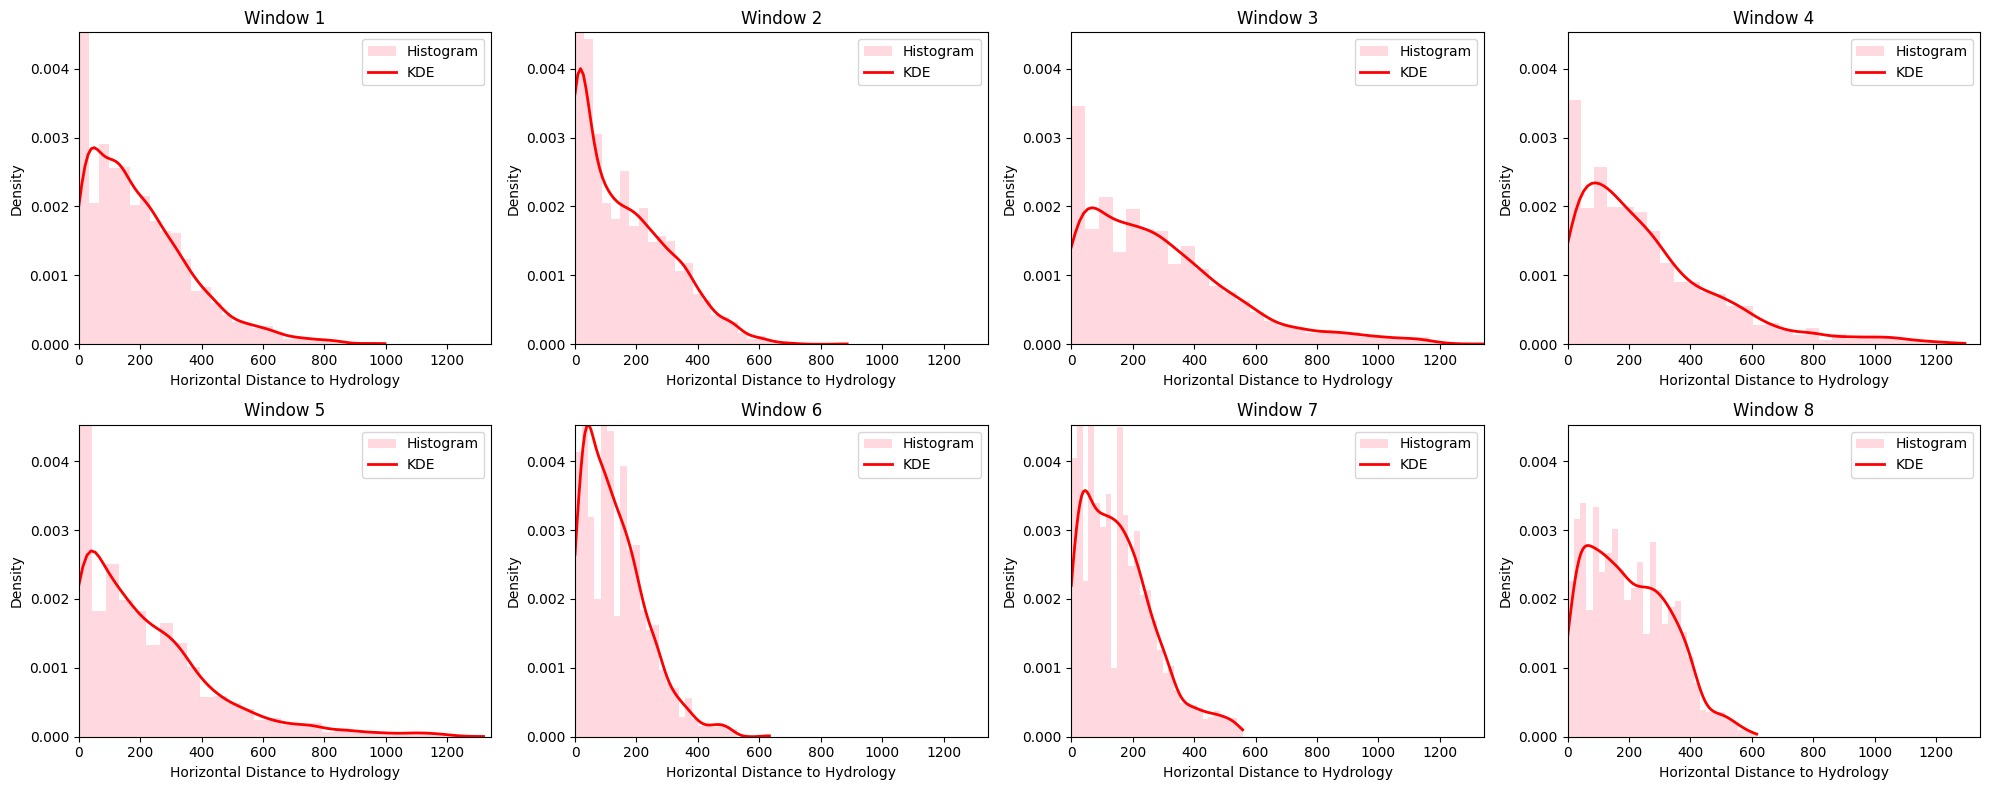

In [16]:
# Define the feature to analyze
feature_idx =3   # Index of "Horizontal Distance to Hydrology" in the features list
feature_name = "Horizontal Distance to Hydrology"

# Number of bins for the histogram
num_bins = 30

# Compute the x-axis limits based on the entire dataset for this feature
x_min = features_df.iloc[:, feature_idx].min()
x_max = features_df.iloc[:, feature_idx].max()

# Determine y-axis limits based on maximum KDE density across all windows
y_max = 0
for i in range(num_windows):
    window_data = features_df.iloc[i * window_size: (i + 1) * window_size, feature_idx]
    kde = gaussian_kde(window_data)
    y_vals = kde(np.linspace(x_min, x_max, 100))
    y_max = max(y_max, y_vals.max())  # Update y_max with the highest density value found

# Plot histograms with KDE lines for each window
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    # Extract feature values for the current window
    window_data = features_df.iloc[i * window_size: (i + 1) * window_size, feature_idx]

    # Plot histogram
    ax.hist(window_data, bins=num_bins, density=True, alpha=0.6, color='pink', label='Histogram')

    # Calculate KDE
    kde = gaussian_kde(window_data)
    x_vals = np.linspace(window_data.min(), window_data.max(), 100)
    y_vals = kde(x_vals)

    # Plot the KDE line
    ax.plot(x_vals, y_vals, color='red', linewidth=2, label='KDE')

    # Set the same x and y limits for all plots
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)

    # Set titles and labels
    ax.set_title(f"Window {i + 1}")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

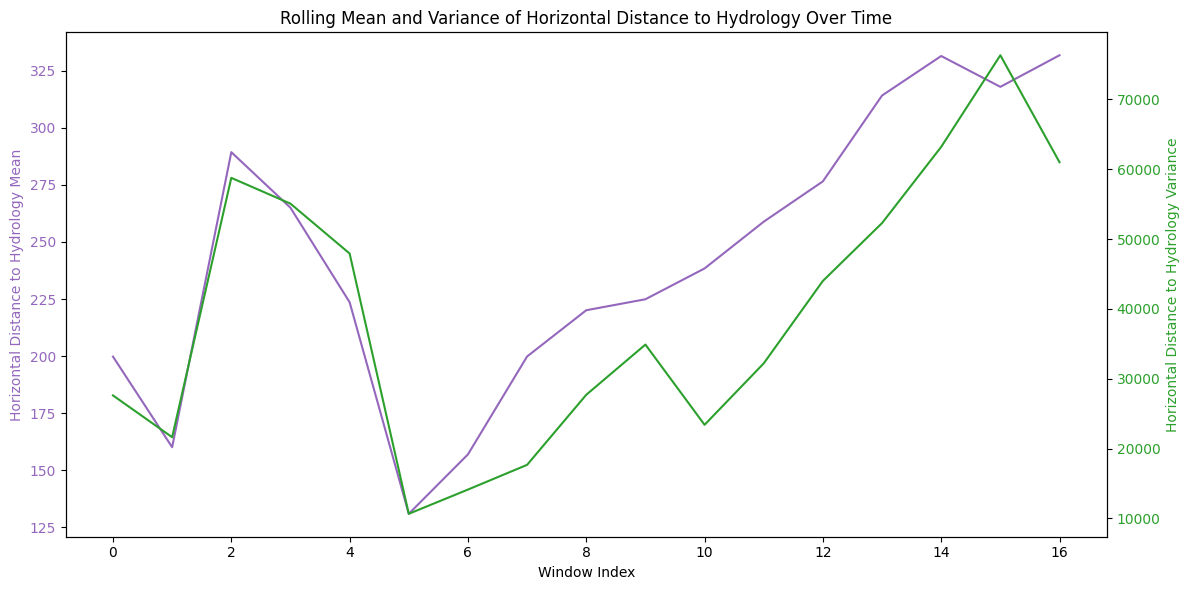

In [17]:
# Define the feature to analyze
feature_idx =3   # Index of "Horizontal Distance to Hydrology" in the features list
feature_name = "Horizontal Distance to Hydrology"

# Calculate rolling mean and variance for the selected feature
rolling_means = []
rolling_variances = []

for i in range(num_windows):
    # Extract the data for the current window
    window_data = features_df.iloc[i*window_size:(i+1)*window_size, feature_idx]
    rolling_means.append(window_data.mean())
    rolling_variances.append(window_data.var())

# Plot the rolling mean and variance over time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Rolling Mean
ax1.set_xlabel("Window Index")
ax1.set_ylabel(f"{feature_name} Mean", color="tab:purple")
ax1.plot(window_indices, rolling_means, label=f"{feature_name} Mean", color="tab:purple")
ax1.tick_params(axis="y", labelcolor="tab:purple")

# Rolling Variance (second y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel(f"{feature_name} Variance", color="tab:green")
ax2.plot(window_indices, rolling_variances, label=f"{feature_name} Variance", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

plt.title(f"Rolling Mean and Variance of {feature_name} Over Time")
fig.tight_layout()
plt.show()

### Vertical Distance to Hydrology

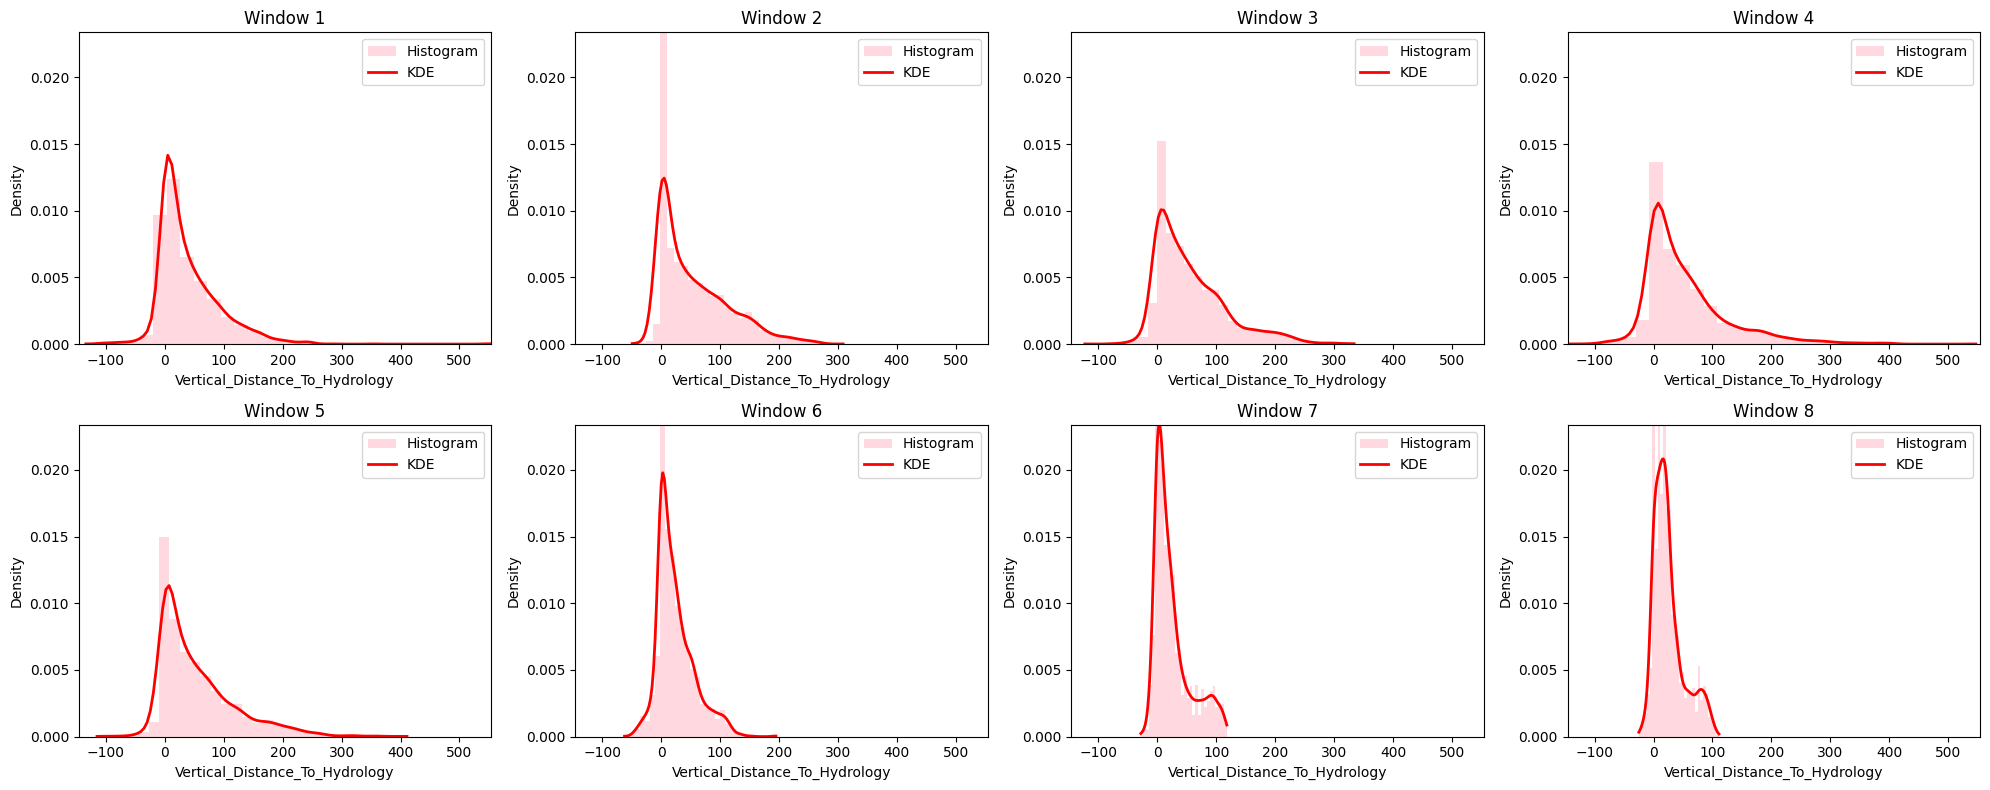

In [18]:
# Define the feature to analyze
feature_idx =4   # Index of "Vertical_Distance_To_Hydrology" in the features list
feature_name = "Vertical_Distance_To_Hydrology"

# Number of bins for the histogram
num_bins = 30

# Compute the x-axis limits based on the entire dataset for this feature
x_min = features_df.iloc[:, feature_idx].min()
x_max = features_df.iloc[:, feature_idx].max()

# Determine y-axis limits based on maximum KDE density across all windows
y_max = 0
for i in range(num_windows):
    window_data = features_df.iloc[i * window_size: (i + 1) * window_size, feature_idx]
    kde = gaussian_kde(window_data)
    y_vals = kde(np.linspace(x_min, x_max, 100))
    y_max = max(y_max, y_vals.max())  # Update y_max with the highest density value found

# Plot histograms with KDE lines for each window
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    # Extract feature values for the current window
    window_data = features_df.iloc[i * window_size: (i + 1) * window_size, feature_idx]

    # Plot histogram
    ax.hist(window_data, bins=num_bins, density=True, alpha=0.6, color='pink', label='Histogram')

    # Calculate KDE
    kde = gaussian_kde(window_data)
    x_vals = np.linspace(window_data.min(), window_data.max(), 100)
    y_vals = kde(x_vals)

    # Plot the KDE line
    ax.plot(x_vals, y_vals, color='red', linewidth=2, label='KDE')

    # Set the same x and y limits for all plots
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)

    # Set titles and labels
    ax.set_title(f"Window {i + 1}")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

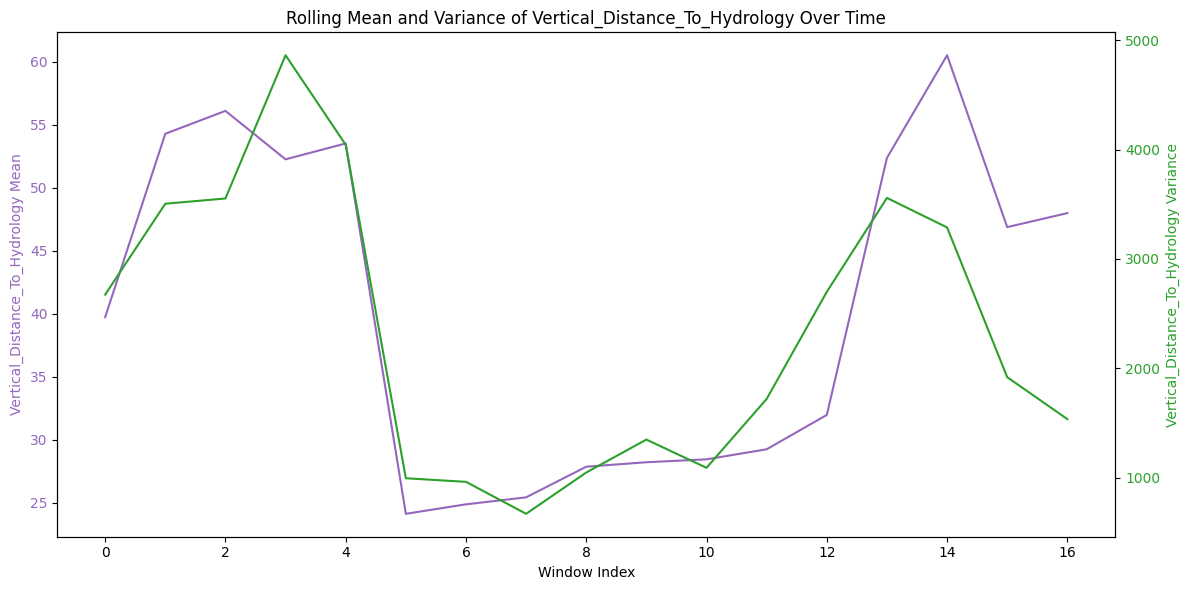

In [19]:
# Define the feature to analyze
feature_idx =4   # Index of "Vertical_Distance_To_Hydrology" in the features list
feature_name = "Vertical_Distance_To_Hydrology"

# Calculate rolling mean and variance for the selected feature
rolling_means = []
rolling_variances = []

for i in range(num_windows):
    # Extract the data for the current window
    window_data = features_df.iloc[i*window_size:(i+1)*window_size, feature_idx]
    rolling_means.append(window_data.mean())
    rolling_variances.append(window_data.var())

# Plot the rolling mean and variance over time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Rolling Mean
ax1.set_xlabel("Window Index")
ax1.set_ylabel(f"{feature_name} Mean", color="tab:purple")
ax1.plot(window_indices, rolling_means, label=f"{feature_name} Mean", color="tab:purple")
ax1.tick_params(axis="y", labelcolor="tab:purple")

# Rolling Variance (second y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel(f"{feature_name} Variance", color="tab:green")
ax2.plot(window_indices, rolling_variances, label=f"{feature_name} Variance", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

plt.title(f"Rolling Mean and Variance of {feature_name} Over Time")
fig.tight_layout()
plt.show()

### Horizontal Distance to Roadways

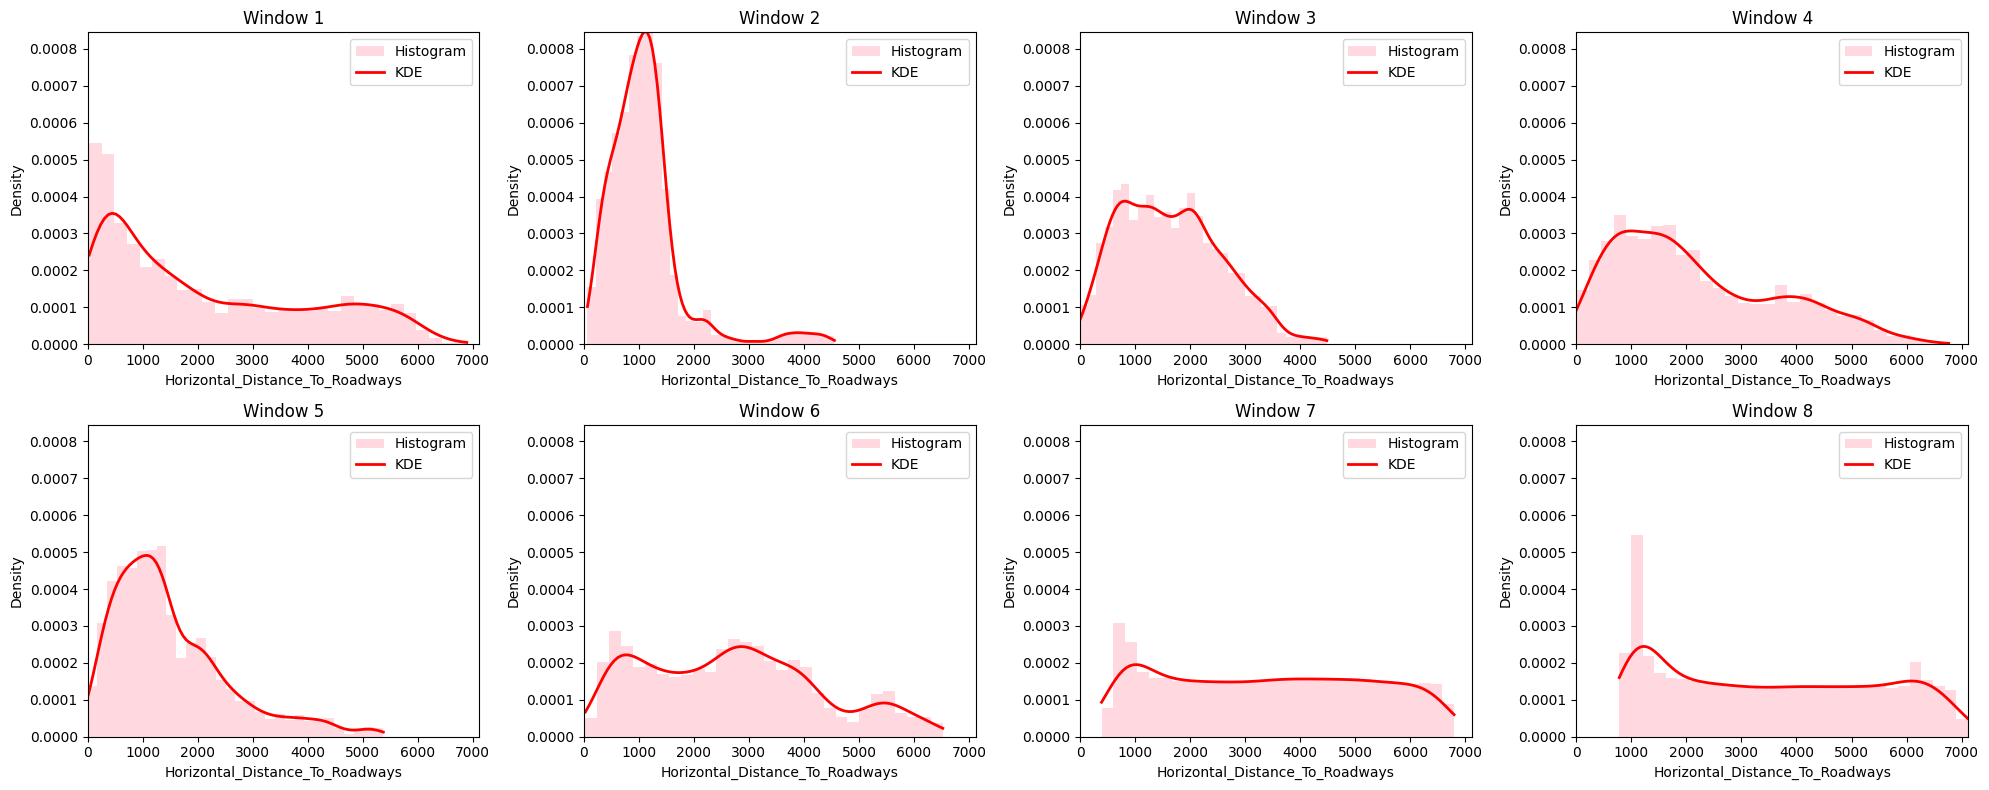

In [20]:
# Define the feature to analyze
feature_idx =5   # Index of "Horizontal_Distance_To_Roadways" in the features list
feature_name = "Horizontal_Distance_To_Roadways"

# Number of bins for the histogram
num_bins = 30

# Compute the x-axis limits based on the entire dataset for this feature
x_min = features_df.iloc[:, feature_idx].min()
x_max = features_df.iloc[:, feature_idx].max()

# Determine y-axis limits based on maximum KDE density across all windows
y_max = 0
for i in range(num_windows):
    window_data = features_df.iloc[i * window_size: (i + 1) * window_size, feature_idx]
    kde = gaussian_kde(window_data)
    y_vals = kde(np.linspace(x_min, x_max, 100))
    y_max = max(y_max, y_vals.max())  # Update y_max with the highest density value found

# Plot histograms with KDE lines for each window
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    # Extract feature values for the current window
    window_data = features_df.iloc[i * window_size: (i + 1) * window_size, feature_idx]

    # Plot histogram
    ax.hist(window_data, bins=num_bins, density=True, alpha=0.6, color='pink', label='Histogram')

    # Calculate KDE
    kde = gaussian_kde(window_data)
    x_vals = np.linspace(window_data.min(), window_data.max(), 100)
    y_vals = kde(x_vals)

    # Plot the KDE line
    ax.plot(x_vals, y_vals, color='red', linewidth=2, label='KDE')

    # Set the same x and y limits for all plots
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)

    # Set titles and labels
    ax.set_title(f"Window {i + 1}")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

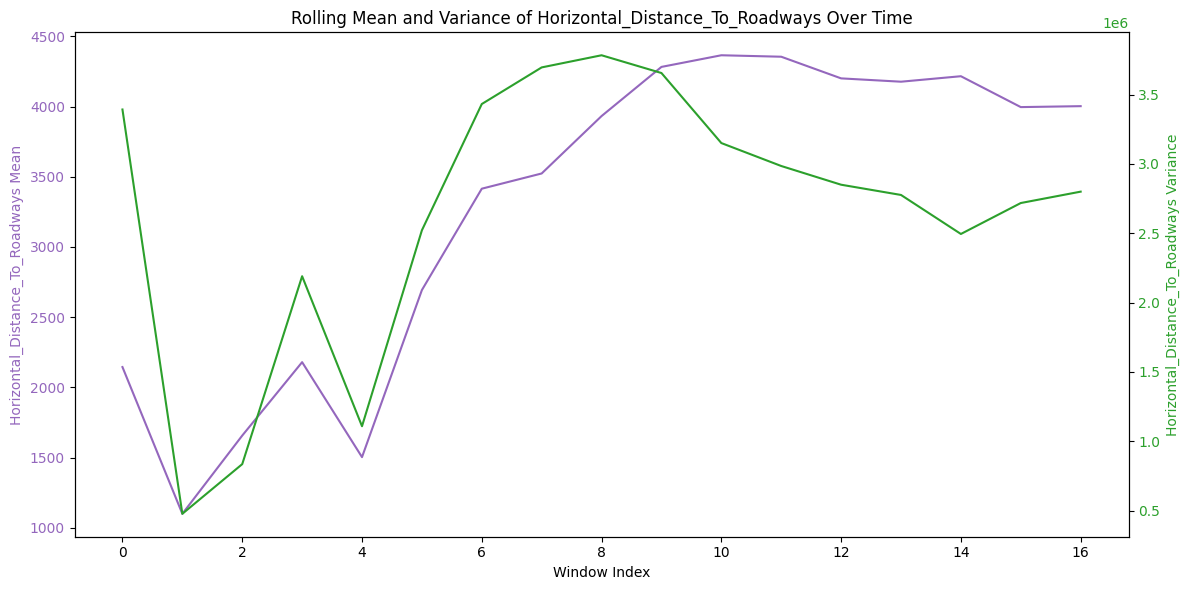

In [21]:
# Define the feature to analyze
feature_idx =5   # Index of "Horizontal_Distance_To_Roadways" in the features list
feature_name = "Horizontal_Distance_To_Roadways"

# Calculate rolling mean and variance for the selected feature
rolling_means = []
rolling_variances = []

for i in range(num_windows):
    # Extract the data for the current window
    window_data = features_df.iloc[i*window_size:(i+1)*window_size, feature_idx]
    rolling_means.append(window_data.mean())
    rolling_variances.append(window_data.var())

# Plot the rolling mean and variance over time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Rolling Mean
ax1.set_xlabel("Window Index")
ax1.set_ylabel(f"{feature_name} Mean", color="tab:purple")
ax1.plot(window_indices, rolling_means, label=f"{feature_name} Mean", color="tab:purple")
ax1.tick_params(axis="y", labelcolor="tab:purple")

# Rolling Variance (second y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel(f"{feature_name} Variance", color="tab:green")
ax2.plot(window_indices, rolling_variances, label=f"{feature_name} Variance", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

plt.title(f"Rolling Mean and Variance of {feature_name} Over Time")
fig.tight_layout()
plt.show()

### Hillshade 9am

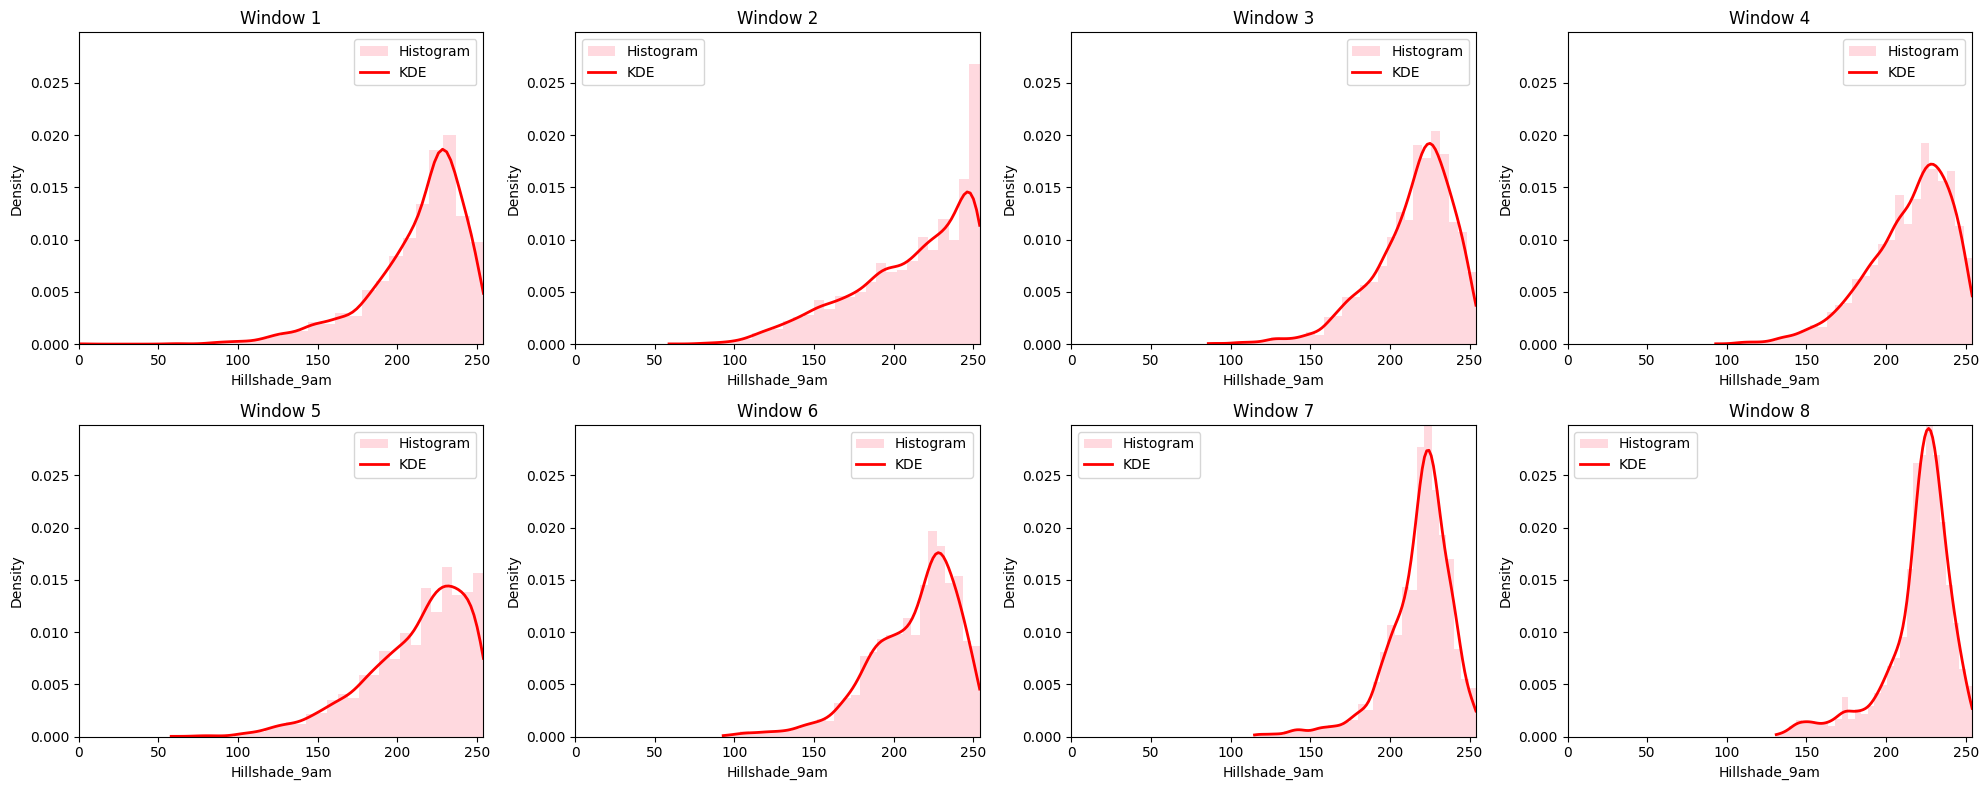

In [22]:
# Define the feature to analyze
feature_idx =6   # Index of "Hillshade_9am" in the features list
feature_name = "Hillshade_9am"

# Number of bins for the histogram
num_bins = 30

# Compute the x-axis limits based on the entire dataset for this feature
x_min = features_df.iloc[:, feature_idx].min()
x_max = features_df.iloc[:, feature_idx].max()

# Determine y-axis limits based on maximum KDE density across all windows
y_max = 0
for i in range(num_windows):
    window_data = features_df.iloc[i * window_size: (i + 1) * window_size, feature_idx]
    kde = gaussian_kde(window_data)
    y_vals = kde(np.linspace(x_min, x_max, 100))
    y_max = max(y_max, y_vals.max())  # Update y_max with the highest density value found

# Plot histograms with KDE lines for each window
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    # Extract feature values for the current window
    window_data = features_df.iloc[i * window_size: (i + 1) * window_size, feature_idx]

    # Plot histogram
    ax.hist(window_data, bins=num_bins, density=True, alpha=0.6, color='pink', label='Histogram')

    # Calculate KDE
    kde = gaussian_kde(window_data)
    x_vals = np.linspace(window_data.min(), window_data.max(), 100)
    y_vals = kde(x_vals)

    # Plot the KDE line
    ax.plot(x_vals, y_vals, color='red', linewidth=2, label='KDE')

    # Set the same x and y limits for all plots
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)

    # Set titles and labels
    ax.set_title(f"Window {i + 1}")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

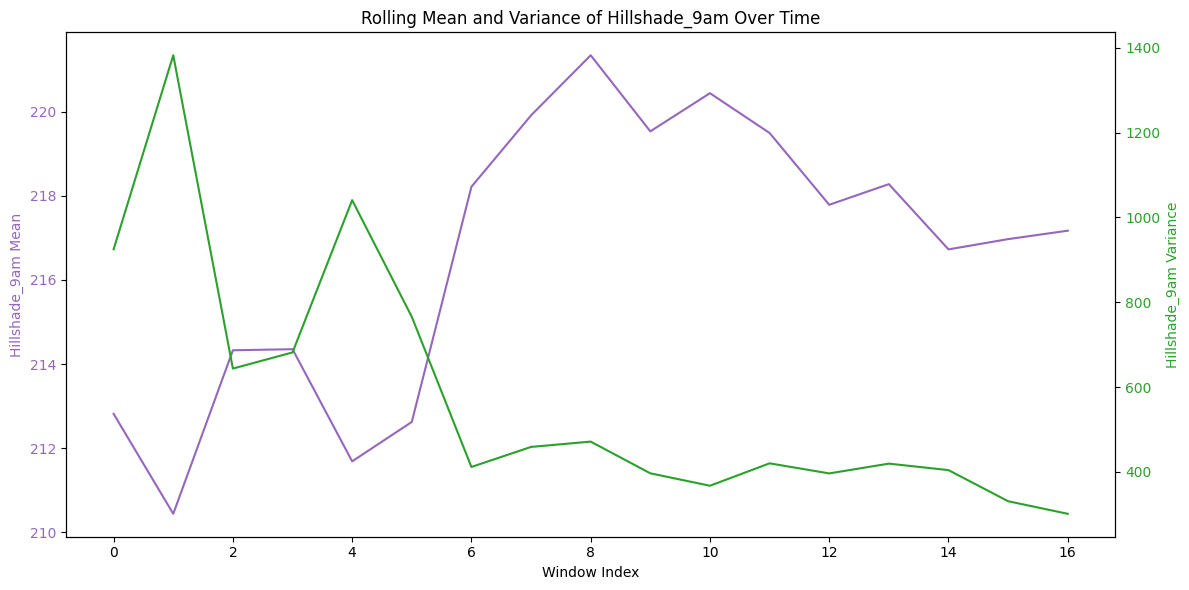

In [23]:
# Define the feature to analyze
feature_idx =6   # Index of "Hillshade_9am" in the features list
feature_name = "Hillshade_9am"

# Calculate rolling mean and variance for the selected feature
rolling_means = []
rolling_variances = []

for i in range(num_windows):
    # Extract the data for the current window
    window_data = features_df.iloc[i*window_size:(i+1)*window_size, feature_idx]
    rolling_means.append(window_data.mean())
    rolling_variances.append(window_data.var())

# Plot the rolling mean and variance over time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Rolling Mean
ax1.set_xlabel("Window Index")
ax1.set_ylabel(f"{feature_name} Mean", color="tab:purple")
ax1.plot(window_indices, rolling_means, label=f"{feature_name} Mean", color="tab:purple")
ax1.tick_params(axis="y", labelcolor="tab:purple")

# Rolling Variance (second y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel(f"{feature_name} Variance", color="tab:green")
ax2.plot(window_indices, rolling_variances, label=f"{feature_name} Variance", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

plt.title(f"Rolling Mean and Variance of {feature_name} Over Time")
fig.tight_layout()
plt.show()

## Plotting the Distribution of some Categorical Features Over Time
### Wilderness Areas

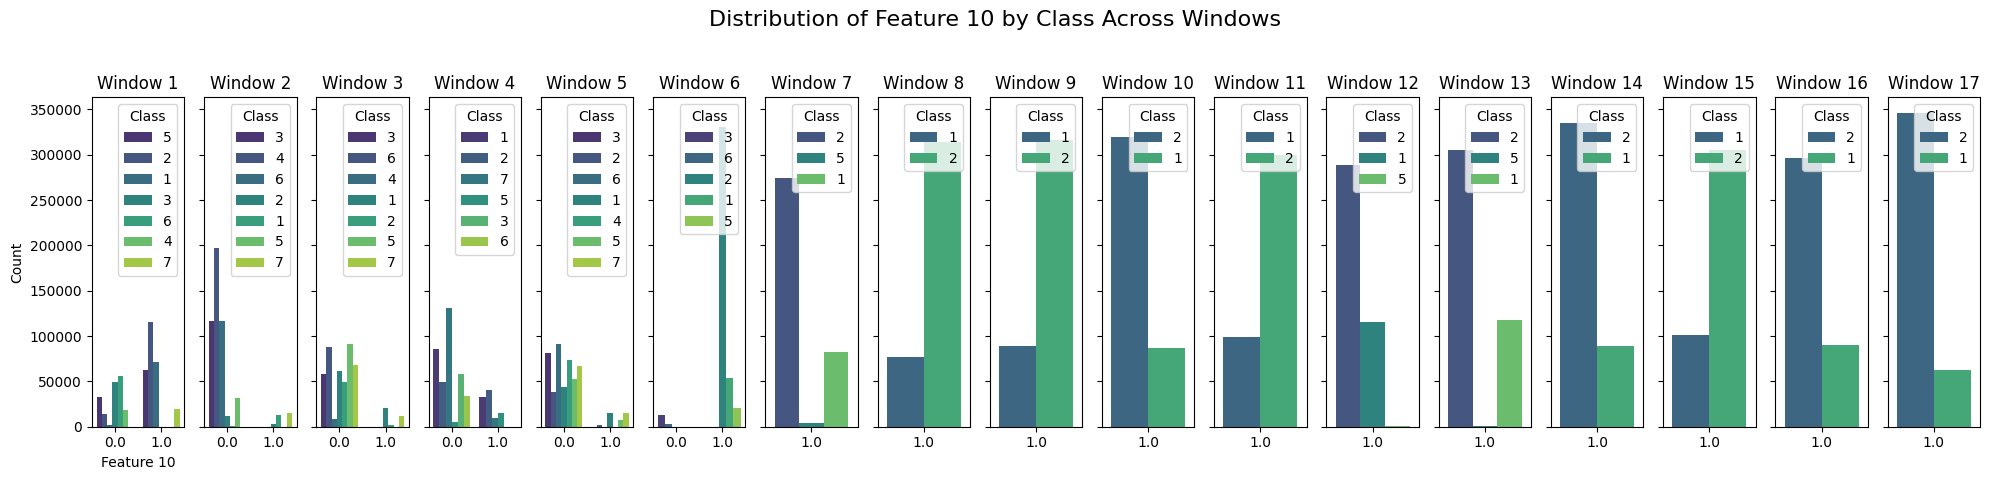

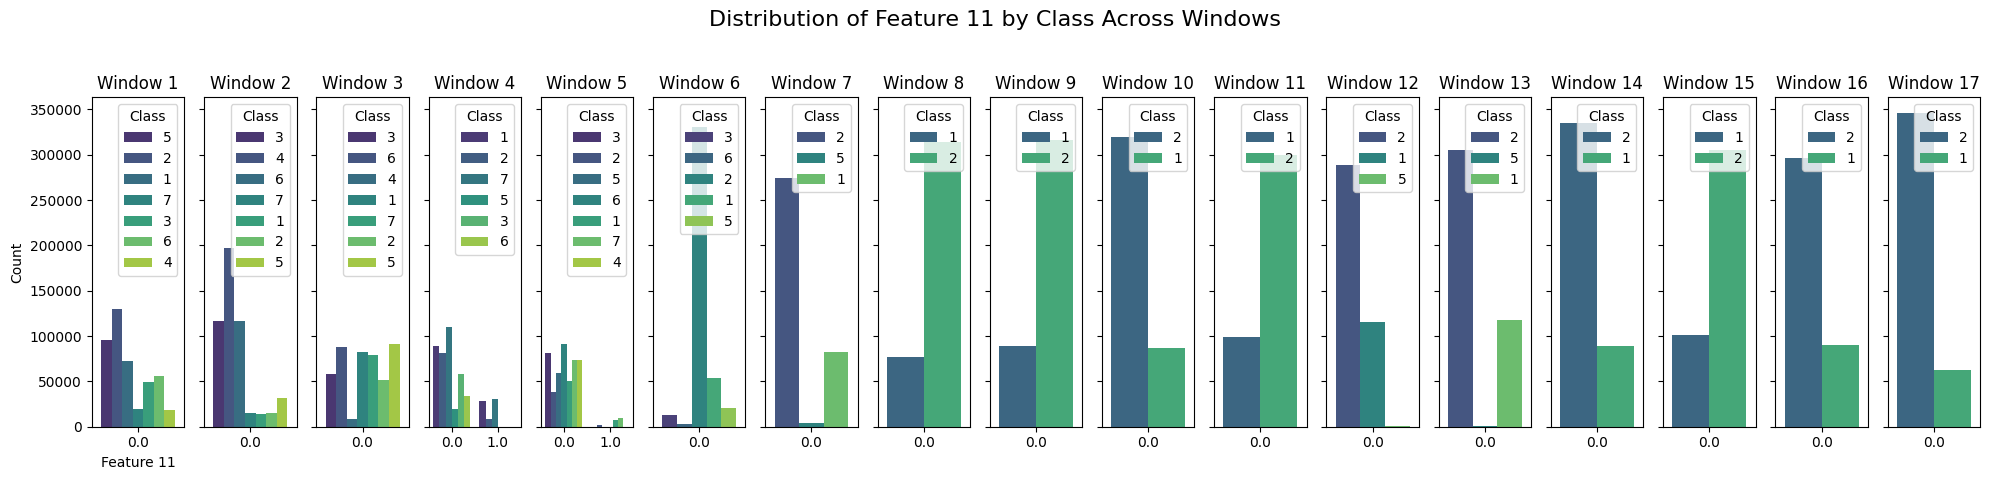

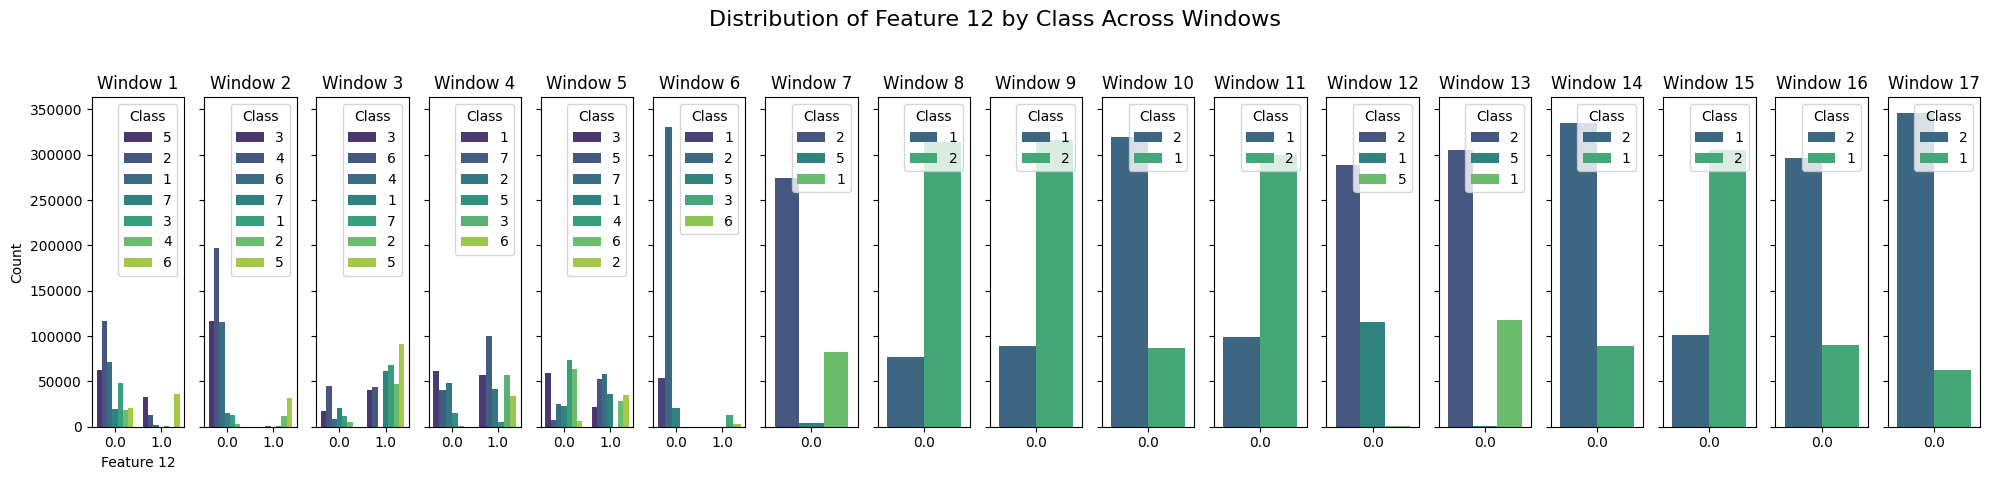

In [24]:
import seaborn as sns
# Selected categorical features to visualize
categorical_features_to_plot = categorical_features[0:3]  # Select some categorical features as an example

# Loop through each categorical feature
for feature_idx in categorical_features_to_plot:
    feature_name = f"Feature {feature_idx}"

    # Set up the plot layout for each categorical feature
    fig, axes = plt.subplots(1, num_windows, figsize=(20, 5), sharey=True)
    fig.suptitle(f"Distribution of {feature_name} by Class Across Windows", fontsize=16)

    # Loop through each window
    for i in range(num_windows):
        # Extract the data for the current window
        window_start = i * window_size
        window_end = (i + 1) * window_size
        window_data = features_df.iloc[window_start:window_end, :]
        window_label_data = label_df.iloc[window_start:window_end, :]

        # Plot count plot for the categorical feature in the current window
        sns.countplot(
            data=window_data,
            x=window_data.iloc[:, feature_idx],  # Select the categorical feature
            hue=window_label_data.iloc[:, -1],
            palette="viridis",
            ax=axes[i]
        )

        # Set title and labels for each subplot
        axes[i].set_title(f"Window {i + 1}")
        axes[i].set_xlabel(feature_name if i == 0 else "")
        axes[i].set_ylabel("Count" if i == 0 else "")
        axes[i].legend(title="Class", loc="upper right")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Soil Types

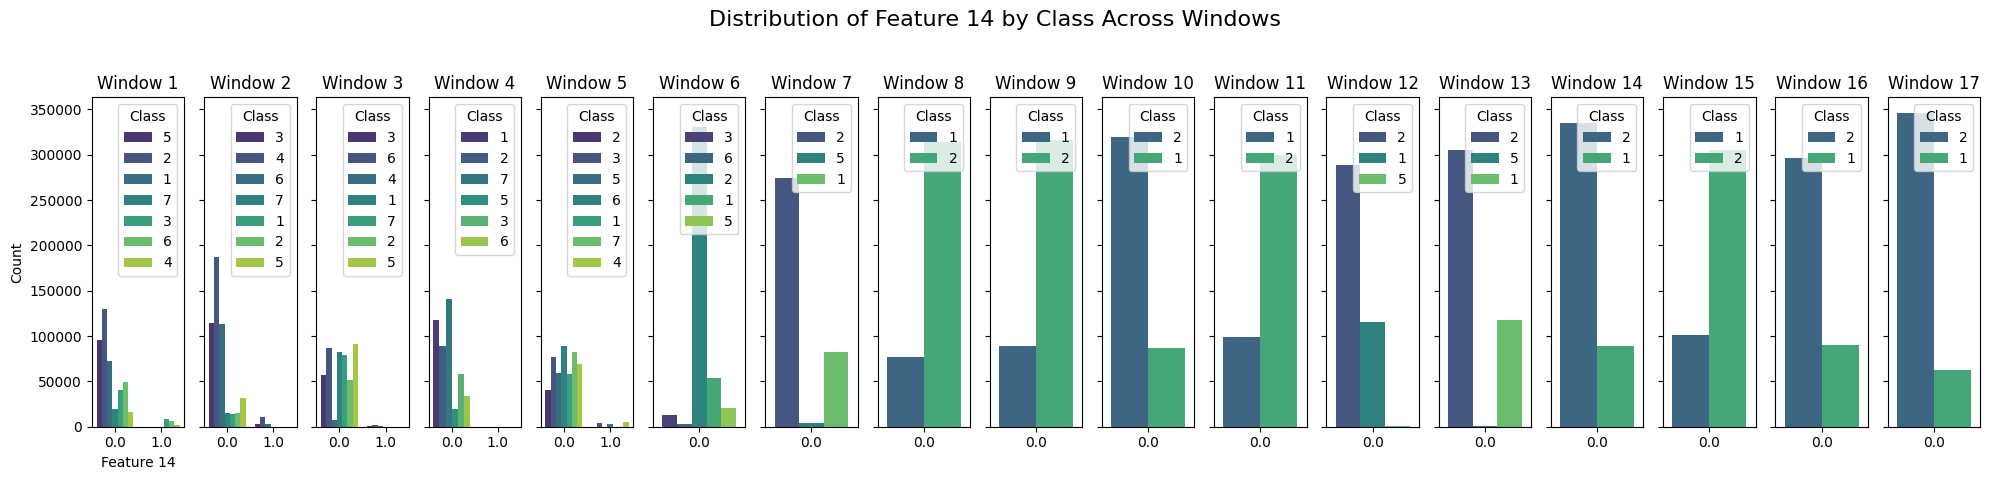

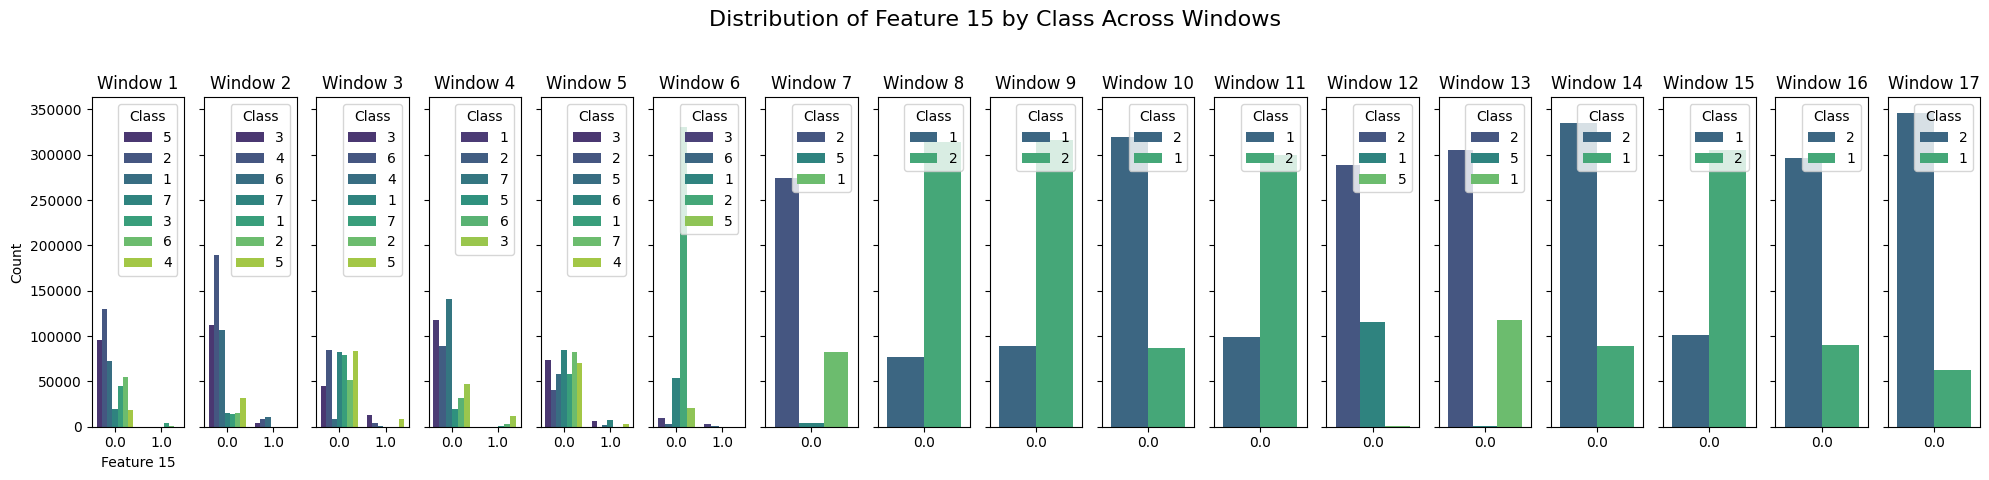

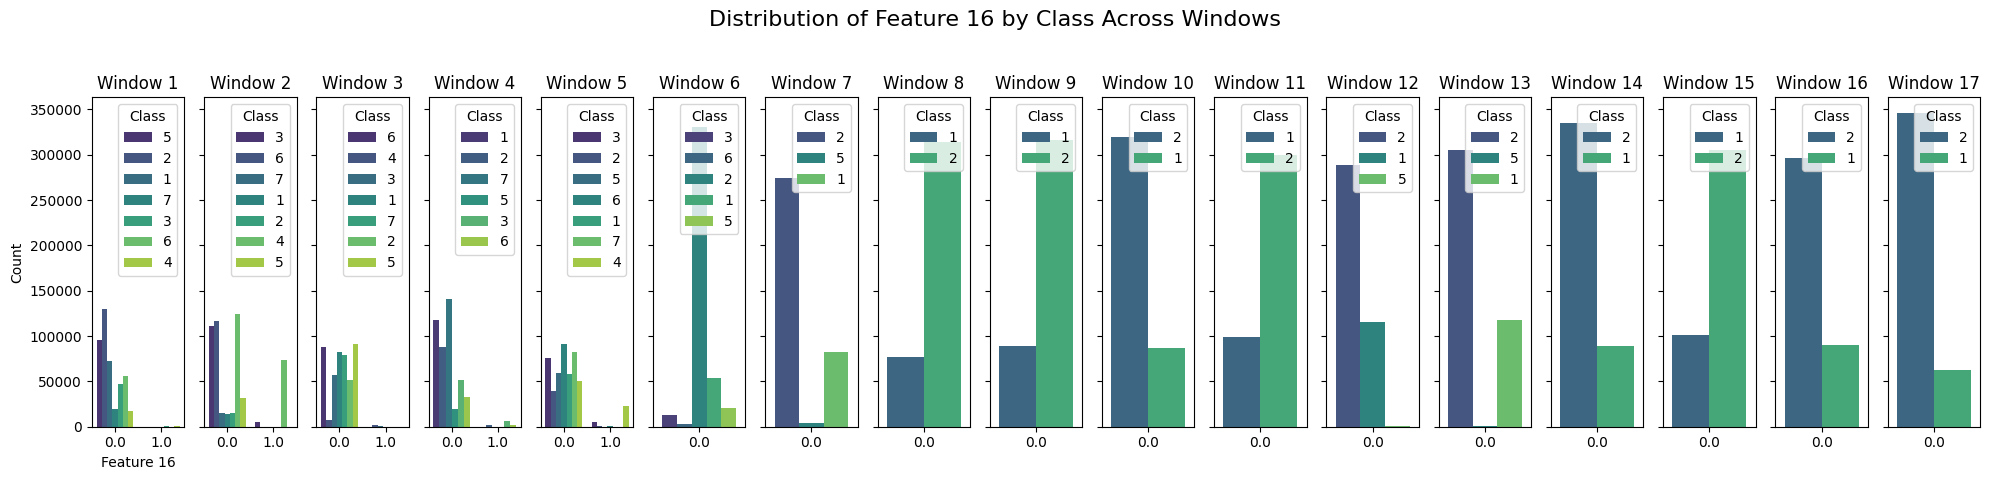

In [25]:
import seaborn as sns
# Selected categorical features to visualize
categorical_features_to_plot = categorical_features[4:7]  # Select some categorical features as an example

# Loop through each categorical feature
for feature_idx in categorical_features_to_plot:
    feature_name = f"Feature {feature_idx}"

    # Set up the plot layout for each categorical feature
    fig, axes = plt.subplots(1, num_windows, figsize=(20, 5), sharey=True)
    fig.suptitle(f"Distribution of {feature_name} by Class Across Windows", fontsize=16)

    # Loop through each window
    for i in range(num_windows):
        # Extract the data for the current window
        window_start = i * window_size
        window_end = (i + 1) * window_size
        window_data = features_df.iloc[window_start:window_end, :]
        window_label_data = label_df.iloc[window_start:window_end, :]

        # Plot count plot for the categorical feature in the current window
        sns.countplot(
            data=window_data,
            x=window_data.iloc[:, feature_idx],  # Select the categorical feature
            hue=window_label_data.iloc[:, -1],
            palette="viridis",
            ax=axes[i]
        )

        # Set title and labels for each subplot
        axes[i].set_title(f"Window {i + 1}")
        axes[i].set_xlabel(feature_name if i == 0 else "")
        axes[i].set_ylabel("Count" if i == 0 else "")
        axes[i].legend(title="Class", loc="upper right")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Experimental Setting

## Algorithms and Evaluation Metric

### Performing Random Search to Find Better Hyperparameters For the Chosen Models (Evaluation Metric Kappa_m)

In [ ]:
import random
import numpy as np
from capymoa.classifier import NaiveBayes

max_instances = total_samples
# Define hyperparameter search space
param_grid_ht = {
    'grace_period': [50, 100, 150, 200],
    'confidence': [0.0001, 0.001, 0.005, 0.01],
    'tie_threshold': [0.001, 0.01, 0.05, 0.1],
    'leaf_prediction': [0, 1, 2],
    'nb_threshold': [5, 10, 20, 30],
    'binary_split': [True, False],
    'remove_poor_attrs': [True, False]
}

param_grid_arf = {
    'ensemble_size': [50, 100, 200],         # Number of trees in the forest
    'max_features': [0.3, 0.6, 1.0],         # Fraction of features for each split
    'lambda_param': [1.0, 6.0, 10.0],        # Sampling frequency
    'random_seed': [1, 42, 100],             # Random seed for reproducibility
    'minibatch_size': [1, 10, 50]            # Batch size per learning iteration
}

param_grid_ob = {
    'ensemble_size': [50, 100, 200],      # Number of models in the ensemble
    'minibatch_size': [1, 10, 50],        # Batch size per training iteration
    'random_seed': [1, 42, 100]           # Random seed for reproducibility
}

# Function to perform random search
def random_search(n_iterations):
    best_kappam_ht = -np.inf
    best_kappam_arf = -np.inf
    best_kappam_ob = -np.inf
    best_params_ht = None
    best_params_arf = None
    best_params_ob = None

    for i in range(n_iterations):
        # Randomly sample hyperparameters
        params1 = {
            'grace_period': random.choice(param_grid_ht['grace_period']),
            'confidence': random.choice(param_grid_ht['confidence']),
            'tie_threshold': random.choice(param_grid_ht['tie_threshold']),
            'leaf_prediction': random.choice(param_grid_ht['leaf_prediction']),
            'nb_threshold': random.choice(param_grid_ht['nb_threshold']),
            'binary_split': random.choice(param_grid_ht['binary_split']),
            'remove_poor_attrs': random.choice(param_grid_ht['remove_poor_attrs'])
        }

        # Initialize Hoeffding Tree with sampled hyperparameters
        ht_random = HoeffdingTree(
            schema=stream.get_schema(),
            grace_period=params1['grace_period'],
            confidence=params1['confidence'],
            tie_threshold=params1['tie_threshold'],
            leaf_prediction=params1['leaf_prediction'],
            nb_threshold=params1['nb_threshold'],
            binary_split=params1['binary_split'],
            remove_poor_attrs=params1['remove_poor_attrs']
        )

        params2 = {
                'ensemble_size': random.choice(param_grid_arf['ensemble_size']),
                'max_features': random.choice(param_grid_arf['max_features']),
                'lambda_param': random.choice(param_grid_arf['lambda_param']),
                'random_seed': random.choice(param_grid_arf['random_seed']),
                'minibatch_size': random.choice(param_grid_arf['minibatch_size'])
            }
        arf_random = AdaptiveRandomForestClassifier(
                schema=stream.get_schema(),
                ensemble_size=params2['ensemble_size'],
                max_features=params2['max_features'],
                lambda_param=params2['lambda_param'],
                random_seed=params2['random_seed'],
                minibatch_size=params2['minibatch_size']
            )

        params3 = {
                'ensemble_size': random.choice(param_grid_ob['ensemble_size']),
                'minibatch_size': random.choice(param_grid_ob['minibatch_size']),
                'random_seed': random.choice(param_grid_ob['random_seed'])
            }
        ob_random = OnlineBagging(
                schema=stream.get_schema(),
                ensemble_size=params3['ensemble_size'],
                minibatch_size=params3['minibatch_size'],
                random_seed=params3['random_seed']
            )
        # Evaluate performance
        results_random_ht = prequential_evaluation(stream=stream, learner=ht_random, window_size=window_size, max_instances=max_instances)
        results_random_arf = prequential_evaluation(stream=stream, learner=arf_random, window_size=window_size, max_instances=max_instances)
        results_random_ob = prequential_evaluation(stream=stream, learner=ob_random, window_size=window_size, max_instances=max_instances)

        # Calculate kappa_m
        kappam_ht = results_random_ht.cumulative.kappa_m()
        kappam_arf = results_random_arf.cumulative.kappa_m()
        kappam_ob = results_random_ob.cumulative.kappa_m()

        print(f"Iteration {i+1}: Kappam_ht = {kappam_ht}, Params = {params1}")
        print(f"Iteration {i+1}: Kappam_arf = {kappam_arf}, Params = {params2}")
        print(f"Iteration {i+1}: Kappam_ob = {kappam_ob}, Params = {params3}")

        # Track best hyperparameters
        if kappam_ht > best_kappam_ht:
            best_kappam_ht = kappam_ht
            best_params_ht = params1
        if kappam_arf > best_kappam_arf:
            best_kappam_arf = kappam_arf
            best_params_arf = params2
        if kappam_ob > best_kappam_ob:
            best_kappam_ob = kappam_ob
            best_params_ob = params3


    return best_params_ht, best_kappam_ht, best_params_arf, best_kappam_arf, best_params_ob, best_kappam_ob

# Perform random search over 20 iterations
best_params_ht, best_kappam_ht, best_params_arf, best_kappam_arf, best_params_ob, best_kappam_ob = random_search(n_iterations=5)

print(f"Best Kappa-m of HoeffdingTree: {best_kappam_ht}")
print(f"Best Hyperparameters of HoeffdingTree: {best_params_ht}")
print(f"Best Kappa-m  of AdaptiveRandomForest: {best_kappam_arf}")
print(f"Best Hyperparameters of AdaptiveRandomForest: {best_params_arf}")
print(f"Best Kappa-m  of OnlineBagging: {best_kappam_ob}")
print(f"Best Hyperparameters of OnlineBagging: {best_params_ob}")

Iteration 1: Kappam_ht = 57.895965633171464, Params = {'grace_period': 100, 'confidence': 0.01, 'tie_threshold': 0.05, 'leaf_prediction': 2, 'nb_threshold': 30, 'binary_split': True, 'remove_poor_attrs': False}
Iteration 1: Kappam_arf = 69.50410907732535, Params = {'ensemble_size': 50, 'max_features': 1.0, 'lambda_param': 1.0, 'random_seed': 100, 'minibatch_size': 10}
Iteration 1: Kappam_ob = 51.031938737392615, Params = {'ensemble_size': 50, 'minibatch_size': 1, 'random_seed': 42}
Iteration 2: Kappam_ht = 52.871684721703396, Params = {'grace_period': 100, 'confidence': 0.01, 'tie_threshold': 0.001, 'leaf_prediction': 2, 'nb_threshold': 5, 'binary_split': True, 'remove_poor_attrs': False}
Iteration 2: Kappam_arf = 57.424355621964885, Params = {'ensemble_size': 50, 'max_features': 0.3, 'lambda_param': 1.0, 'random_seed': 1, 'minibatch_size': 1}
Iteration 2: Kappam_ob = 48.29566679118417, Params = {'ensemble_size': 200, 'minibatch_size': 50, 'random_seed': 42}
Iteration 3: Kappam_ht = 29

### Definining the new models with the Best Hyperparameters Found

In [ ]:
stream = Covtype()
schema = stream.get_schema()

mc = MajorityClass(schema=stream.get_schema())
nc=NoChange(schema=stream.get_schema())

ht_best = HoeffdingTree(
            schema=stream.get_schema(),
            grace_period=best_params_ht['grace_period'],
            confidence=best_params_ht['confidence'],
            tie_threshold=best_params_ht['tie_threshold'],
            leaf_prediction=best_params_ht['leaf_prediction'],
            nb_threshold=best_params_ht['nb_threshold'],
            binary_split=best_params_ht['binary_split'],
            remove_poor_attrs=best_params_ht['remove_poor_attrs'])

arf_best = AdaptiveRandomForestClassifier(
                schema=stream.get_schema(),
                ensemble_size=best_params_arf['ensemble_size'],
                max_features=best_params_arf['max_features'],
                lambda_param=best_params_arf['lambda_param'],
                random_seed=best_params_arf['random_seed'],
                minibatch_size=best_params_arf['minibatch_size'])

ob_best = OnlineBagging(
                schema=stream.get_schema(),
                ensemble_size=best_params_ob['ensemble_size'],
                minibatch_size=best_params_ob['minibatch_size'],
                random_seed=best_params_ob['random_seed']
            )

# Evaluate performance
mc_results = prequential_evaluation(stream=stream, learner=mc, window_size=window_size, max_instances=max_instances)
nc_results = prequential_evaluation(stream=stream, learner=nc, window_size=window_size, max_instances=max_instances)
results_ht = prequential_evaluation(stream=stream, learner=ht_best, window_size=window_size, max_instances=max_instances)
results_arf = prequential_evaluation(stream=stream, learner=arf_best, window_size=window_size, max_instances=max_instances)
results_ob = prequential_evaluation(stream=stream, learner=ob_best, window_size=window_size, max_instances=max_instances)

## Results And Analysis

### Windowed Results(Table)

In [ ]:
print("Majority Class")
display(mc_results.windowed.metrics_per_window().iloc[:,:5])
print()
print("No Change")
display(nc_results.windowed.metrics_per_window().iloc[:,:5])
print()
print("Hoeffding Tree")
display(results_ht.windowed.metrics_per_window().iloc[:,:5])
print()
print("Adaptive Random Forest")
display(results_arf.windowed.metrics_per_window().iloc[:,:5])
print()
print("Online Bagging")
display(results_ob.windowed.metrics_per_window().iloc[:,:5])

Majority Class


,instances,accuracy,kappa,kappa_t,kappa_m
0,3000.0,29.766667,0.072736,-59.621212,-0.285578
1,6000.0,21.300000,-7.826978,-118.207024,-14.002897
2,9000.0,2.800000,0.000000,-99.726027,-9.871891
3,12000.0,9.433333,0.512390,-101.259259,-24.007303
4,15000.0,8.500000,-8.062570,-60.151692,-0.109409
5,18000.0,76.933333,13.316882,-314.371257,27.463312
6,21000.0,78.633333,0.000000,-828.985507,0.000000
7,24000.0,82.300000,0.000000,-883.333333,0.000000
8,27000.0,82.500000,0.000000,-564.556962,0.000000
9,30000.0,80.633333,0.000000,-423.423423,0.000000



No Change


,instances,accuracy,kappa,kappa_t,kappa_m
0,3000.0,56.000000,44.558338,0.0,37.172775
1,6000.0,63.933333,48.446027,0.0,47.754708
2,9000.0,51.333333,41.855618,0.0,44.988696
3,12000.0,55.000000,43.489731,0.0,38.384299
4,15000.0,42.866667,32.836973,0.0,37.490883
5,18000.0,94.433333,85.572421,0.0,82.494759
6,21000.0,97.700000,93.277911,0.0,89.235569
7,24000.0,98.200000,93.821694,0.0,89.830508
8,27000.0,97.366667,90.887069,0.0,84.952381
9,30000.0,96.300000,88.145416,0.0,80.895009



Hoeffding Tree


,instances,accuracy,kappa,kappa_t,kappa_m
0,3000.0,67.266667,58.693799,25.606061,53.260352
1,6000.0,74.666667,63.205926,29.759704,63.302752
2,9000.0,65.000000,58.124020,28.082192,60.437076
3,12000.0,71.933333,64.588997,37.629630,61.570059
4,15000.0,69.100000,63.592848,45.915986,66.192560
5,18000.0,82.766667,55.740204,-209.580838,45.807128
6,21000.0,91.500000,76.297620,-269.565217,60.218409
7,24000.0,94.233333,81.170621,-220.370370,67.419962
8,27000.0,94.600000,81.817161,-105.063291,69.142857
9,30000.0,92.933333,76.157576,-90.990991,63.511188



Adaptive Random Forest


,instances,accuracy,kappa,kappa_t,kappa_m
0,3000.0,76.666667,70.402847,46.969697,66.682532
1,6000.0,83.800000,76.610169,55.083179,76.533076
2,9000.0,78.600000,74.449514,56.027397,75.810098
3,12000.0,79.333333,73.922271,54.074074,71.702419
4,15000.0,74.233333,69.659785,54.900817,71.808899
5,18000.0,89.033333,70.626530,-97.005988,65.513627
6,21000.0,94.500000,84.318576,-139.130435,74.258970
7,24000.0,96.666667,88.524767,-85.185185,81.167608
8,27000.0,96.100000,86.877524,-48.101266,77.714286
9,30000.0,92.733333,76.487253,-96.396396,62.478485



Online Bagging


,instances,accuracy,kappa,kappa_t,kappa_m
0,3000.0,65.566667,57.040952,21.742424,50.832937
1,6000.0,67.233333,51.598680,9.149723,52.535007
2,9000.0,55.766667,46.918719,9.109589,50.000000
3,12000.0,69.600000,62.046567,32.444444,58.375171
4,15000.0,66.233333,60.311418,40.898483,63.056163
5,18000.0,80.266667,50.193910,-254.491018,37.945493
6,21000.0,84.066667,58.020610,-592.753623,25.429017
7,24000.0,80.766667,49.578319,-968.518519,-8.662900
8,27000.0,79.433333,45.334131,-681.012658,-17.523810
9,30000.0,77.866667,43.825960,-498.198198,-14.285714


### Windowed Results (Plots For Chosen Evaluation Metrics)

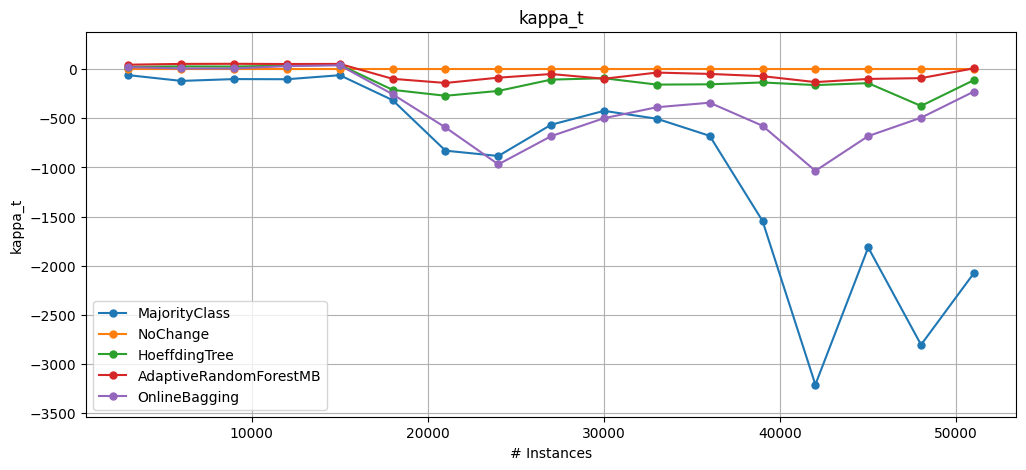

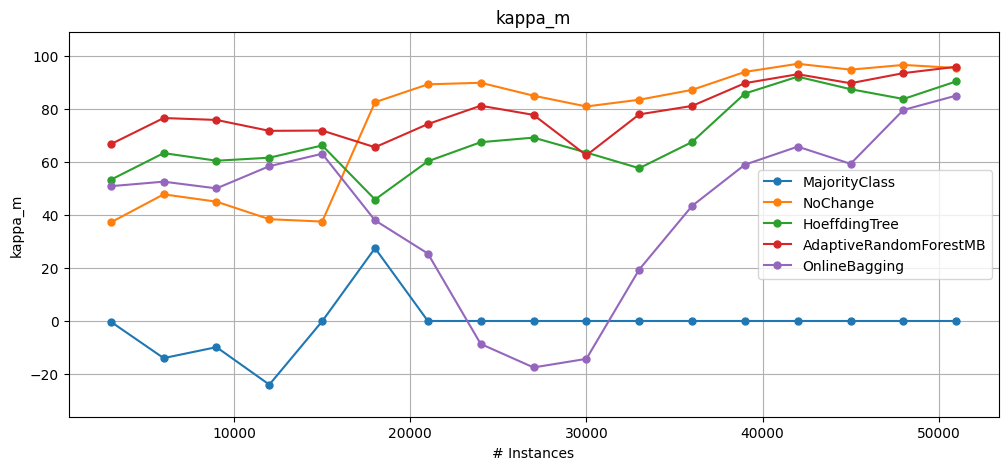

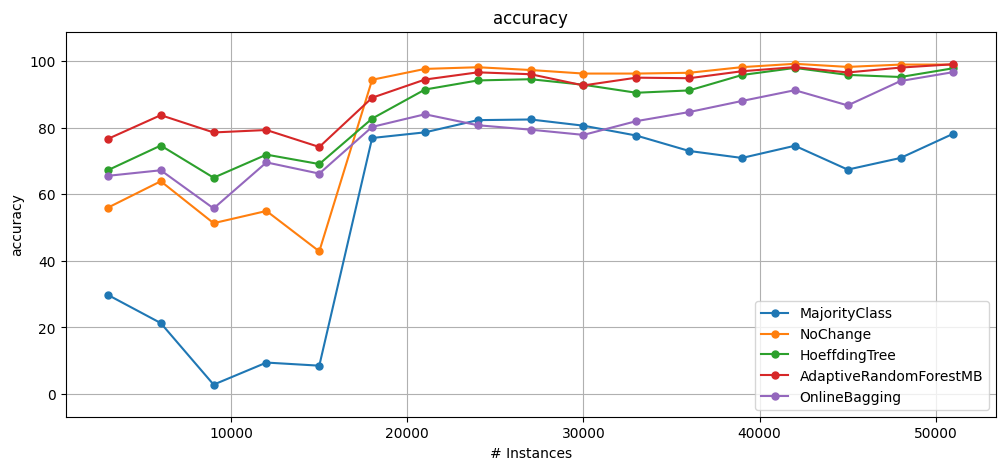

In [ ]:
from capymoa.evaluation.visualization import plot_windowed_results

# Plot results
plot_windowed_results(mc_results,nc_results, results_ht,results_arf,results_ob, metric="kappa_t")
# Plot results
plot_windowed_results(mc_results,nc_results, results_ht,results_arf,results_ob, metric="kappa_m") # We have decided to work primarily on kappa_m and kappa_t(to some extent), the other metrics are just for display
# Plot results
plot_windowed_results(mc_results,nc_results, results_ht,results_arf,results_ob, metric="accuracy")

### Cumulative Results

In [ ]:
import pandas as pd

# Collect cumulative metrics
metrics_nc = nc_results.cumulative.metrics()
metrics_mc = mc_results.cumulative.metrics()
metrics_ht= results_ht.cumulative.metrics()
metrics_arf = results_arf.cumulative.metrics()
metrics_ob = results_ob.cumulative.metrics()

metrics_wallclock_nc = nc_results.wallclock()
metrics_wallclock_mc = mc_results.wallclock()
metrics_wallclock_ht = results_ht.wallclock()
metrics_wallclock_arf = results_arf.wallclock()
metrics_wallclock_ob = results_ob.wallclock()


print("Wallclock Time for No Change:")
print(metrics_wallclock_nc)
print("\nWallclock Time for Majority Class:")
print(metrics_wallclock_mc)
print("\nWallclock Time for Hoeffding Tree:")
print(metrics_wallclock_ht)
print("\nWallclock Time for Adaptive Random Forest:")
print(metrics_wallclock_arf)
print("\nWallclock Time for Online Bagging:")
print(metrics_wallclock_ob)

# Create a DataFrame from the metrics
metrics_data = {
    'Metric': results_ht.metrics_header(),
    'NC': metrics_nc,
    'MC': metrics_mc,
    'HT': metrics_ht,
    'ARF': metrics_arf,
    'OB': metrics_ob
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.head(5)

# Create a dictionary for the wallclock time row
wallclock_row = {
    'Metric': 'wallclock_time',
    'NC': metrics_wallclock_nc,
    'MC': metrics_wallclock_mc,
    'HT': metrics_wallclock_ht,
    'ARF': metrics_wallclock_arf,
    'OB': metrics_wallclock_ob
}
# Convert wallclock_row to a DataFrame
wallclock_df = pd.DataFrame([wallclock_row])  # Enclose wallclock_row in a list

# Concatenate the DataFrames
metrics_df = pd.concat([metrics_df, wallclock_df], ignore_index=True)

# Display the DataFrame
metrics_df

Wallclock Time for No Change:
0.7802865505218506

Wallclock Time for Majority Class:
0.5143754482269287

Wallclock Time for Hoeffding Tree:
1.4403703212738037

Wallclock Time for Adaptive Random Forest:
452.52471804618835

Wallclock Time for Online Bagging:
37.86352610588074


,Metric,NC,MC,HT,ARF,OB
0,instances,51000.000000,51000.000000,51000.000000,51000.000000,51000.000000
1,accuracy,84.690196,57.978431,86.394118,90.629412,79.437255
2,kappa,75.022176,18.842297,77.826122,84.706600,66.841548
3,kappa_t,0.000000,-174.474898,11.129611,38.793545,-34.310963
4,kappa_m,63.541278,-0.070041,67.598991,77.684908,51.031939
5,wallclock_time,0.780287,0.514375,1.440370,452.524718,37.863526


### Plotting the Wallclock Times

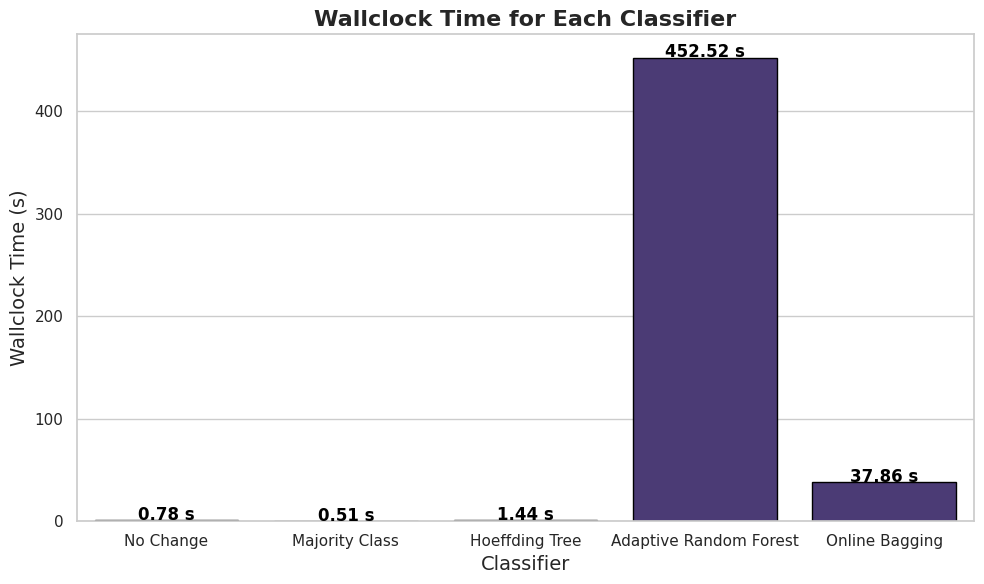

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame specifically for the wallclock times
wallclock_data = {
    'Classifier': ['No Change','Majority Class', 'Hoeffding Tree', 'Adaptive Random Forest', 'Online Bagging'],
    'Wallclock Time (s)': [metrics_wallclock_nc, metrics_wallclock_mc, metrics_wallclock_ht, metrics_wallclock_arf, metrics_wallclock_ob]
}

wallclock_df = pd.DataFrame(wallclock_data)

# Set the style and color palette for a visually appealing plot
sns.set(style="whitegrid")
sns.set_palette("viridis")

# Create a bar plot for the wallclock times
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    x='Classifier',
    y='Wallclock Time (s)',
    data=wallclock_df,
    edgecolor="black"
)

# Add titles and labels
plt.title("Wallclock Time for Each Classifier", fontsize=16, weight='bold')
plt.xlabel("Classifier", fontsize=14)
plt.ylabel("Wallclock Time (s)", fontsize=14)

# Customize the bars with value labels for clarity
for i, value in enumerate(wallclock_df['Wallclock Time (s)']):
    barplot.text(
        i, value + 0.1,  # Position above the bar
        f"{value:.2f} s",  # Format to 2 decimal places
        color='black',
        ha="center",
        fontsize=12,
        fontweight='bold'
    )

# Display the plot
plt.tight_layout()
plt.show()


## Concept Drift Analysis

In [ ]:
import capymoa.stream.generator as generator

In [ ]:
from capymoa.drift.detectors import ADWIN, SEED
from capymoa.classifier import HoeffdingTree
from capymoa.base import Classifier
from capymoa.evaluation import ClassificationEvaluator

### Drift Detection for ht_best using ADWIN

Change detected at instance: 1567
Change detected at instance: 1663
Change detected at instance: 3551
Change detected at instance: 3615
Change detected at instance: 3647
Change detected at instance: 3679
Change detected at instance: 7455
Change detected at instance: 9279
Change detected at instance: 9375
Change detected at instance: 15327
Change detected at instance: 15359
Change detected at instance: 15391
Change detected at instance: 15423
Change detected at instance: 17823
Change detected at instance: 18431
Change detected at instance: 24479
Change detected at instance: 24735
Change detected at instance: 38431
Change detected at instance: 38591
Change detected at instance: 38815
Change detected at instance: 39199
Change detected at instance: 39679
Change detected at instance: 39807
Change detected at instance: 39839
Change detected at instance: 39999
Change detected at instance: 43935
Change detected at instance: 50111
Final Accuracy: 87.98823529411764


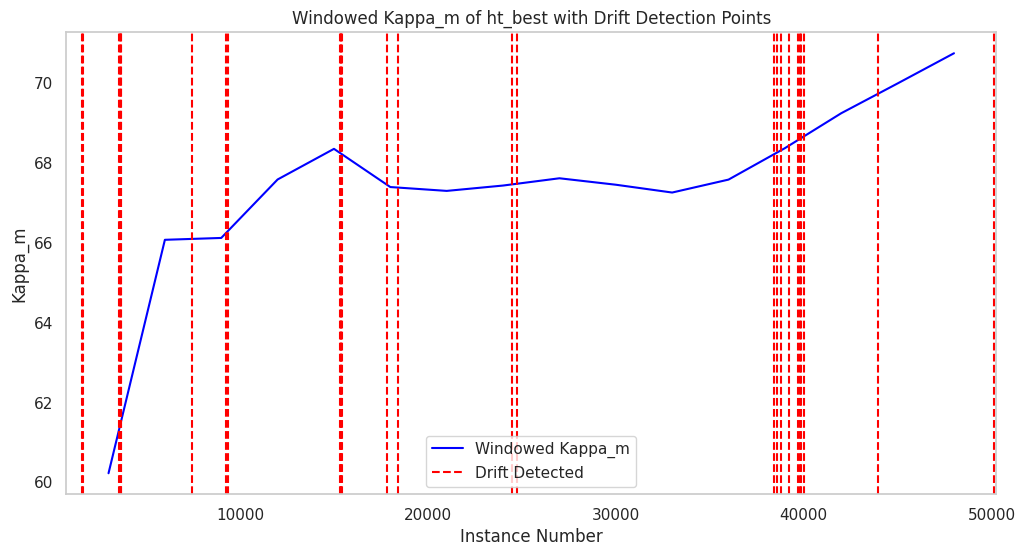

Number of drifts detected: 27


In [ ]:
evaluator = ClassificationEvaluator(schema=stream.get_schema())

detector = ADWIN(delta=0.001)
stream = Covtype()
schema = stream.get_schema()

# Initialize variables to store kappa_m values and drift points
kappa_m_values = []
drift_indices = []

# Iterate over the data stream
i = 0
window_size = window_size  # Adjust window size based on desired granularity
max_instances = max_instances  # Set max instances or your defined max_instances

while stream.has_more_instances() and i < max_instances:
    instance = stream.next_instance()
    pred_ht_best = ht_best.predict(instance)

    # Update evaluator with the true and predicted labels
    evaluator.update(instance.y_index, pred_ht_best)

    # Track kappa_m value every 'window_size' instances
    if i % window_size == 0 and i != 0:
        kappa_m_values.append(evaluator.kappa_m())  # Store windowed kappa_m

    # Detect drift using ADWIN
    is_correct = int(pred_ht_best == instance.y_index)
    detector.add_element(is_correct)
    if detector.detected_change():
        print('Change detected at instance: ' + str(i))
        drift_indices.append(i)  # Store drift point

    # Train the model on the current instance
    ht_best.train(instance)
    i += 1

# Final accuracy output
print(f"Final Accuracy: {evaluator.accuracy()}")

# Plot windowed kappa_m values and detected drifts
plt.figure(figsize=(12, 6))
plt.plot(range(window_size, window_size * len(kappa_m_values) + 1, window_size), kappa_m_values, label='Windowed Kappa_m', color='blue')
plt.xlabel("Instance Number")
plt.ylabel("Kappa_m")
plt.title("Windowed Kappa_m of ht_best with Drift Detection Points")

# Add vertical lines at drift points
for drift_index in drift_indices:
    plt.axvline(x=drift_index, color='red', linestyle='--', label='Drift Detected' if drift_index == drift_indices[0] else "")

# Add legend and grid
plt.legend()
plt.grid()
plt.show()


# How many drifts were detected?
print(f'Number of drifts detected: {len(detector.detection_index)}')

### Drift Detection for arf_best using ADWIN

Change detected at instance: 2111
Change detected at instance: 3615
Change detected at instance: 3679
Change detected at instance: 15359
Change detected at instance: 15391
Change detected at instance: 15455
Change detected at instance: 15519
Change detected at instance: 18047
Change detected at instance: 18591
Change detected at instance: 21599
Change detected at instance: 21823
Change detected at instance: 21855
Change detected at instance: 31519
Change detected at instance: 38463
Change detected at instance: 39263
Change detected at instance: 39487
Change detected at instance: 40447
Change detected at instance: 48319
Change detected at instance: 49567
Final Accuracy: 90.64117647058823


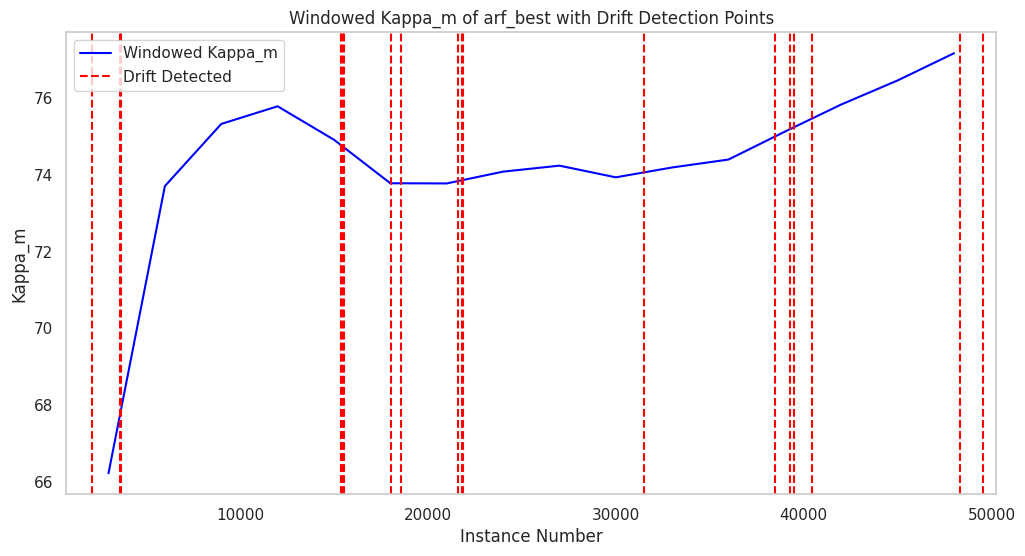

Number of drifts detected: 19


In [ ]:
evaluator = ClassificationEvaluator(schema=stream.get_schema())

detector = ADWIN(delta=0.001)
stream = Covtype()
schema = stream.get_schema()

# Initialize variables to store kappa_m values and drift points
kappa_m_values = []
drift_indices = []

# Iterate over the data stream
i = 0
window_size = window_size  # Adjust window size based on desired granularity
max_instances = max_instances  # Set max instances or your defined max_instances

while stream.has_more_instances() and i < max_instances:
    instance = stream.next_instance()
    pred_arf_best = arf_best.predict(instance)

    # Update evaluator with the true and predicted labels
    evaluator.update(instance.y_index, pred_arf_best)

    # Track kappa_m value every 'window_size' instances
    if i % window_size == 0 and i != 0:
        kappa_m_values.append(evaluator.kappa_m())  # Store windowed kappa_m

    # Detect drift using ADWIN
    is_correct = int(pred_arf_best == instance.y_index)
    detector.add_element(is_correct)
    if detector.detected_change():
        print('Change detected at instance: ' + str(i))
        drift_indices.append(i)  # Store drift point

    # Train the model on the current instance
    arf_best.train(instance)
    i += 1

# Final accuracy output
print(f"Final Accuracy: {evaluator.accuracy()}")

# Plot windowed kappa_m values and detected drifts
plt.figure(figsize=(12, 6))
plt.plot(range(window_size, window_size * len(kappa_m_values) + 1, window_size), kappa_m_values, label='Windowed Kappa_m', color='blue')
plt.xlabel("Instance Number")
plt.ylabel("Kappa_m")
plt.title("Windowed Kappa_m of arf_best with Drift Detection Points")

# Add vertical lines at drift points
for drift_index in drift_indices:
    plt.axvline(x=drift_index, color='red', linestyle='--', label='Drift Detected' if drift_index == drift_indices[0] else "")

# Add legend and grid
plt.legend()
plt.grid()
plt.show()


# How many drifts were detected?
print(f'Number of drifts detected: {len(detector.detection_index)}')

### Drift Detection for ob_best using ADWIN

Change detected at instance: 2047
Change detected at instance: 3007
Change detected at instance: 3071
Change detected at instance: 3423
Change detected at instance: 3455
Change detected at instance: 3551
Change detected at instance: 3647
Change detected at instance: 7519
Change detected at instance: 7615
Change detected at instance: 9183
Change detected at instance: 9247
Change detected at instance: 10879
Change detected at instance: 11039
Change detected at instance: 14495
Change detected at instance: 14559
Change detected at instance: 15231
Change detected at instance: 15487
Change detected at instance: 15519
Change detected at instance: 19167
Change detected at instance: 19199
Change detected at instance: 21311
Change detected at instance: 21567
Change detected at instance: 24767
Change detected at instance: 24991
Change detected at instance: 31519
Change detected at instance: 33087
Change detected at instance: 34239
Change detected at instance: 38079
Change detected at instance: 38

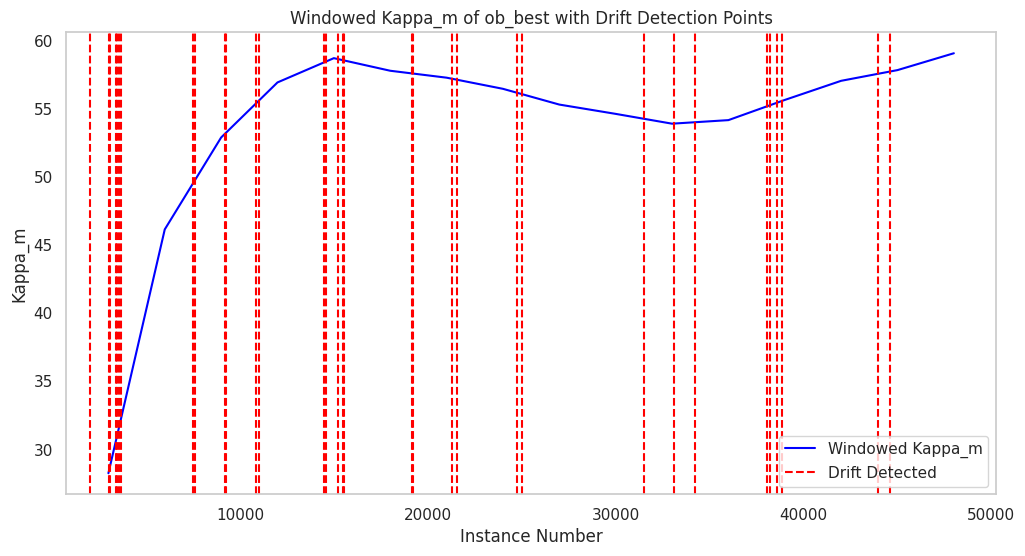

Number of drifts detected: 33


In [ ]:
evaluator = ClassificationEvaluator(schema=stream.get_schema())

detector = ADWIN(delta=0.001)
stream = Covtype()
schema = stream.get_schema()

# Initialize variables to store kappa_m values and drift points
kappa_m_values = []
drift_indices = []

# Iterate over the data stream
i = 0
window_size = window_size  # Adjust window size based on desired granularity
max_instances = max_instances  # Set max instances or your defined max_instances

while stream.has_more_instances() and i < max_instances:
    instance = stream.next_instance()
    pred_ob_best = ob_best.predict(instance)

    # Update evaluator with the true and predicted labels
    evaluator.update(instance.y_index, pred_ob_best)

    # Track kappa_m value every 'window_size' instances
    if i % window_size == 0 and i != 0:
        kappa_m_values.append(evaluator.kappa_m())  # Store windowed kappa_m

    # Detect drift using ADWIN
    is_correct = int(pred_ob_best == instance.y_index)
    detector.add_element(is_correct)
    if detector.detected_change():
        print('Change detected at instance: ' + str(i))
        drift_indices.append(i)  # Store drift point

    # Train the model on the current instance
    ob_best.train(instance)
    i += 1

# Final accuracy output
print(f"Final Accuracy: {evaluator.accuracy()}")

# Plot windowed kappa_m values and detected drifts
plt.figure(figsize=(12, 6))
plt.plot(range(window_size, window_size * len(kappa_m_values) + 1, window_size), kappa_m_values, label='Windowed Kappa_m', color='blue')
plt.xlabel("Instance Number")
plt.ylabel("Kappa_m")
plt.title("Windowed Kappa_m of ob_best with Drift Detection Points")

# Add vertical lines at drift points
for drift_index in drift_indices:
    plt.axvline(x=drift_index, color='red', linestyle='--', label='Drift Detected' if drift_index == drift_indices[0] else "")

# Add legend and grid
plt.legend()
plt.grid()
plt.show()


# How many drifts were detected?
print(f'Number of drifts detected: {len(detector.detection_index)}')

## Drift Detection using DDC(Lab 1)-Only for Hoeffding Tree

In [ ]:
from capymoa.drift.detectors import ADWIN, SEED
from capymoa.classifier import HoeffdingTree
from capymoa.base import Classifier

class DriftDetectionClassifier(Classifier):
    def __init__(self, classifier, drift_detector, min_reset_window=100):
        # delegating schema and random_seed to be set by the super class 'Classifier'
        super().__init__(schema=classifier.schema, random_seed=classifier.random_seed)

        self.classifier = classifier
        # sets the drift detector
        self.drift_detector = drift_detector
        # save the args in case we need to reset the classifier later
        self.classifier_args = self._get_init_args(classifier)

        self.instances_since_last_reset = 0

        self.min_reset_window = min_reset_window

        # Simple counter so that you can make sense of the detections
        self.instances_seen = 0

    def __str__(self):
        return 'DriftDetectionClassifier'

    def train(self, instance):
        self.instances_since_last_reset += 1

        self.instances_seen += 1

        pred = self.classifier.predict(instance)
        y = instance.y_index

        is_correct = int(pred == y)
        self.drift_detector.add_element(is_correct)

        if self.drift_detector.detected_change() and self.instances_since_last_reset >= self.min_reset_window:
            self.instances_since_last_reset = 0
            print(f'Change detected at instance: {self.instances_seen}')
            self.reset()

        self.classifier.train(instance)

    def reset(self, schema=None):

        if schema is not None:
            self.classifier_args['schema'] = schema
        # print (self.classifier_args)
        self.classifier = self.classifier.__class__(schema=self.schema)

        self.classifier.__class__(**self.classifier_args)

    def predict(self, instance):
        return self.classifier.predict(instance)

    def predict_proba(self, instance):
        return self.classifier.predict_proba(instance)

    def _get_init_args(self, obj):
        # filter only the arguments needed for initialization
        init_args = {}
        for param in obj.__init__.__code__.co_varnames:
            if param in obj.__dict__:
                init_args[param] = obj.__dict__[param]
        return init_args

Change detected at instance: 7808
Change detected at instance: 14496
Change detected at instance: 18272
Change detected at instance: 26688
Change detected at instance: 31104
Change detected at instance: 37312
Change detected at instance: 45568
cumulative Kappa-m HT: 67.59899140829286 and DDC: 61.3653343294733


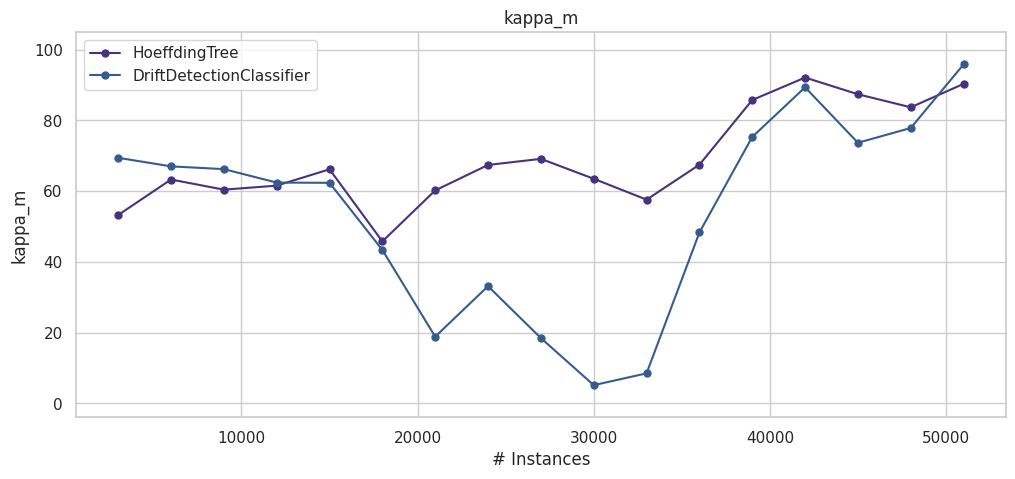

In [ ]:
# create the learner and detector
ht = ht_best
stream = Covtype()
schema = stream.get_schema()

# Change ADWIN delta to adjust the detection sensibility
ddc = DriftDetectionClassifier(
    classifier=ht,
    drift_detector=ADWIN(delta=0.001), #the detector used is still ADWIN (can hypertune delta)
    min_reset_window=3500 #Can hypertune this
)

results2_ht = results_ht
results_ddc = prequential_evaluation(stream=stream, learner=ddc, window_size=window_size, max_instances=max_instances)

print(f"cumulative Kappa-m HT: {results2_ht.cumulative.kappa_m()} and DDC: {results_ddc.cumulative.kappa_m()}")
plot_windowed_results(results2_ht, results_ddc, metric='kappa_m')

# Further Analysis
## Using Pytorch to define our model

In [ ]:
import torch
from torch import nn
import random
random_seed=1
random.seed(random_seed)

torch.manual_seed(random_seed)
torch.use_deterministic_algorithms(True)

# Get cpu device for training.
device = ("cpu")
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=0, number_of_classes=0):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.InstanceNorm1d(512),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.InstanceNorm1d(512),
            nn.Linear(512, number_of_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Using cpu device


## Method 1: Using Instance Loop

In [ ]:
from capymoa.evaluation import ClassificationEvaluator

stream = Covtype()
schema = stream.get_schema()

# Creating the evaluator
evaluator = ClassificationEvaluator(schema=stream.get_schema())

model = None
optimizer = None
loss_fn = nn.CrossEntropyLoss()
# Iterate over the data stream
i = 0
window_size = 3000  # Adjust window size based on desired granularity
max_instances = 51000 # Set max instances or your defined max_instances

while stream.has_more_instances() and i < max_instances:
    i += 1
    instance = stream.next_instance()
    if model is None:
        moa_instance = instance.java_instance.getData()
        # initialize the model and send it to the device
        model = NeuralNetwork(input_size=stream.get_schema().get_num_attributes(),
                              number_of_classes=stream.get_schema().get_num_classes()).to(device)
        # set the optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
        print(model)

    X = torch.tensor(instance.x, dtype=torch.float32)
    y = torch.tensor(instance.y_index, dtype=torch.long)
    # set the device and add a dimension to the tensor
    X, y = torch.unsqueeze(X.to(device), 0), torch.unsqueeze(y.to(device),0)

    # turn off gradient collection for test
    with torch.no_grad():
        pred = model(X)
        prediction = torch.argmax(pred)

    # update evaluator with predicted class
    evaluator.update(instance.y_index, prediction.item())

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if i % window_size == 0 and i!=0 :
        print(f'Accuracy at {i} : {evaluator.accuracy()}')
        print(f'Kappa-m at {i} : {evaluator.kappa_m()}')

print(f'Kappa-m at {i} : {evaluator.accuracy()}')

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=54, out_features=512, bias=True)
    (1): ReLU()
    (2): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): Linear(in_features=512, out_features=7, bias=True)
  )
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


Accuracy at 3000 : 67.96666666666667
Kappa-m at 3000 : 54.259876249405046
Accuracy at 6000 : 69.35
Kappa-m at 6000 : 58.77605917955615
Accuracy at 9000 : 66.27777777777779
Kappa-m at 9000 : 58.858614612986315
Accuracy at 12000 : 68.04166666666667
Kappa-m at 12000 : 61.99583787533446
Accuracy at 15000 : 66.94666666666666
Kappa-m at 15000 : 61.36824061087736
Accuracy at 18000 : 70.60555555555555
Kappa-m at 18000 : 60.87406640538342
Accuracy at 21000 : 74.14285714285714
Kappa-m at 21000 : 61.66337192883367
Accuracy at 24000 : 77.01666666666667
Kappa-m at 24000 : 62.4634229329704
Accuracy at 27000 : 79.11851851851853
Kappa-m at 27000 : 62.95663600525625
Accuracy at 30000 : 80.5
Kappa-m at 30000 : 62.97702677045758
Accuracy at 33000 : 81.4939393939394
Kappa-m at 33000 : 62.922712646469556
Accuracy at 36000 : 82.46388888888889
Kappa-m at 36000 : 63.46643518518519
Accuracy at 39000 : 83.5974358974359
Kappa-m at 39000 : 64.75870427501103
Accuracy at 42000 : 84.71190476190476
Kappa-m at 42000 :

In [ ]:
metrics_nn=evaluator.metrics()
# Create a DataFrame from the metrics
metrics_data = {
    'Metric': evaluator.metrics_header(),
    'NN': metrics_nn
    }

metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
metrics_df.head(5)

,Metric,NN
0,instances,51000.000000
1,accuracy,87.168627
2,kappa,79.174093
3,kappa_t,16.188525
4,kappa_m,69.443407


## Method 2 - Using PyTorch Classifier and Prequential Evaluation

In [ ]:
from capymoa.base import Classifier
import numpy as np

class PyTorchClassifier(Classifier):
    def __init__(self, schema=None, random_seed=1, nn_model: nn.Module = None, optimizer=None, loss_fn=nn.CrossEntropyLoss(), device=("cpu"), lr=1e-3):
        super().__init__(schema, random_seed)
        self.model = None
        self.optimizer = None
        self.loss_fn = loss_fn
        self.lr = lr
        self.device = device

        torch.manual_seed(random_seed)

        if nn_model is None:
            self.set_model(None)
        else:
            self.model = nn_model.to(device)
        if optimizer is None:
            if self.model is not None:
                self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        else:
            self.optimizer = optimizer

    def __str__(self):
        return str(self.model)

    def CLI_help(self):
        return str('schema=None, random_seed=1, nn_model: nn.Module = None, optimizer=None, loss_fn=nn.CrossEntropyLoss(), device=("cpu"), lr=1e-3')

    def set_model(self, instance):
        if self.schema is None:
            moa_instance = instance.java_instance.getData()
            self.model = NeuralNetwork(input_size=moa_instance.get_num_attributes(),
                                       number_of_classes=moa_instance.get_num_classes()).to(self.device)
        elif instance is not None:
            self.model = NeuralNetwork(input_size=self.schema.get_num_attributes(),
                                       number_of_classes=self.schema.get_num_classes()).to(self.device)

    def train(self, instance):
        if self.model is None:
            self.set_model(instance)

        X = torch.tensor(instance.x, dtype=torch.float32)
        y = torch.tensor(instance.y_index, dtype=torch.long)
        # set the device and add a dimension to the tensor
        X, y = torch.unsqueeze(X.to(self.device), 0), torch.unsqueeze(y.to(self.device),0)

        # Compute prediction error
        pred = self.model(X)
        loss = self.loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

    def predict(self, instance):
        return np.argmax(self.predict_proba(instance))

    def predict_proba(self, instance):
        if self.model is None:
            self.set_model(instance)
        X = torch.unsqueeze(torch.tensor(instance.x, dtype=torch.float32).to(self.device), 0)
        # turn off gradient collection
        with torch.no_grad():
            pred = np.asarray(self.model(X).numpy(), dtype=np.double)
        return pred


In [ ]:
from capymoa.evaluation import prequential_evaluation

## Opening a file as a stream
stream = Covtype()
schema = stream.get_schema()

# Creating a learner
simple_pyTorch_classifier = PyTorchClassifier(
    schema=stream.get_schema(),
    nn_model=NeuralNetwork(input_size=stream.get_schema().get_num_attributes(),
                           number_of_classes=stream.get_schema().get_num_classes()).to(device)
)

evaluator = prequential_evaluation(stream=stream, learner=simple_pyTorch_classifier, window_size=3000,max_instances=51000, optimise=False)

print(f"Kappa-m: {evaluator.cumulative.kappa_m()}")

Kappa-m: 69.44340679865523


In [ ]:
metrics_nn=evaluator.metrics()
# Create a DataFrame from the metrics
metrics_data = {
    'Metric': evaluator.metrics_header(),
    'NN': metrics_nn
    }

metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame containing the Cumulative Results
metrics_df.head(5)

,Metric,NN
0,instances,51000.000000
1,accuracy,87.168627
2,kappa,79.174093
3,kappa_t,16.188525
4,kappa_m,69.443407


In [ ]:
# Display Windowed Results (benefit of using prequential_evaluation)
display(evaluator.windowed.metrics_per_window().iloc[:,:5])

,instances,accuracy,kappa,kappa_t,kappa_m
0,3000.0,67.966667,59.610003,27.196970,54.259876
1,6000.0,70.733333,57.236810,18.853974,57.605022
2,9000.0,60.133333,52.170790,18.082192,54.935946
3,12000.0,73.333333,66.375323,40.740741,63.486992
4,15000.0,62.566667,55.785864,34.480747,59.044493
5,18000.0,88.900000,69.803423,-99.401198,65.094340
6,21000.0,95.366667,86.134650,-101.449275,78.315133
7,24000.0,97.133333,90.087210,-59.259259,83.804143
8,27000.0,95.933333,85.958451,-54.430380,76.761905
9,30000.0,92.933333,77.104134,-90.990991,63.511188
